In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor, set_requires_grad

In [ ]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [11]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_pr_cls = discriminator(y_pr.detach())
        x_cls = discriminator(x)
        
        _dis = nn.CrossEntropyLoss()(y_cls.float(), torch.ones(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(x_cls.float(), torch.zeros(x_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), 2 * torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device) )

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        _gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + air_loss + bone_loss
        _loss.backward()    
        gen_optimizer.step()
        

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()

    return  air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [12]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        x_cls = discriminator(x)
        x_cls = Activation(name=DIS_ACT)(x_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        total = x.size()[0]
        _, predicted = torch.max(y_cls.data, 1)
        correct = (predicted == torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(y_pr_cls.data, 1)
        correct = (predicted == 2 * torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(x_cls.data, 1)
        correct = (predicted == torch.zeros(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [13]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, encoder, hidden_ch=2048, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Linear(in_features=hidden_ch, out_features=n_classes)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return self.activation(x)

# Read Data

In [15]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [16]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [17]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [18]:
len(trainset), len(testset)

(1344, 191)

In [19]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7fe6949f9400>,)

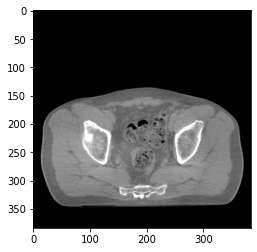

In [20]:
plt.imshow(x.squeeze(), 'gray'),

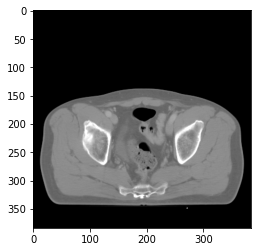

In [21]:
plt.imshow(y.squeeze(), 'gray')

In [22]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [23]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [25]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [26]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [27]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [28]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [03:01,  1.08s/it]
168it [00:47,  3.51it/s]
24it [00:07,  3.37it/s]
168it [03:02,  1.08s/it]
168it [00:47,  3.50it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.34it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:03,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:03,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:03,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.37it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:03,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:03,  1.09s/it]
168it [00:48,

In [29]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [30]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [31]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8429340720176697
psnr score = 22.701370239257812
snr score = 12.764309883117676
mae error = 0.02649918757379055
air dice score = 0.9981220282095356
bone dice score = 0.9556521739136862


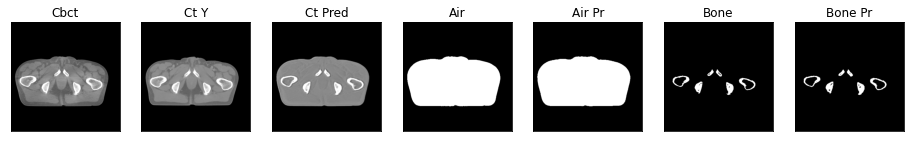

ssim score = 0.8412335515022278
psnr score = 22.600940704345703
snr score = 12.711416244506836
mae error = 0.026791445910930634
air dice score = 0.9981940993943765
bone dice score = 0.9587702916253589


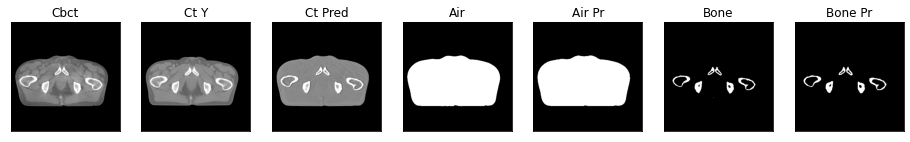

ssim score = 0.8407211899757385
psnr score = 22.60726547241211
snr score = 12.880632400512695
mae error = 0.02692699059844017
air dice score = 0.9982323156664786
bone dice score = 0.9494925084588025


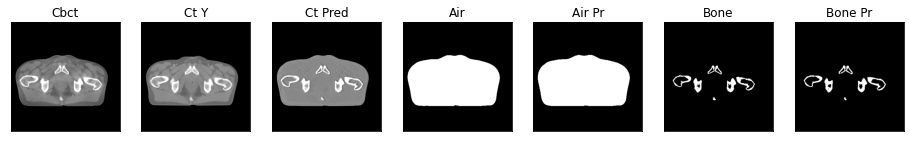

ssim score = 0.8378283381462097
psnr score = 22.599815368652344
snr score = 12.96243667602539
mae error = 0.027520600706338882
air dice score = 0.9982295573893492
bone dice score = 0.9411000433094294


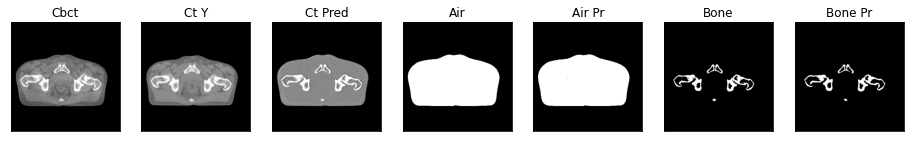

ssim score = 0.8373116850852966
psnr score = 22.61204719543457
snr score = 13.014969825744629
mae error = 0.02809181436896324
air dice score = 0.9982038391683492
bone dice score = 0.9423636716481432


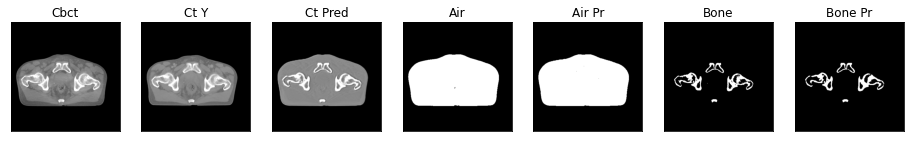

ssim score = 0.8355053067207336
psnr score = 22.563936233520508
snr score = 13.103394508361816
mae error = 0.02855795994400978
air dice score = 0.9981051443315614
bone dice score = 0.936300463269885


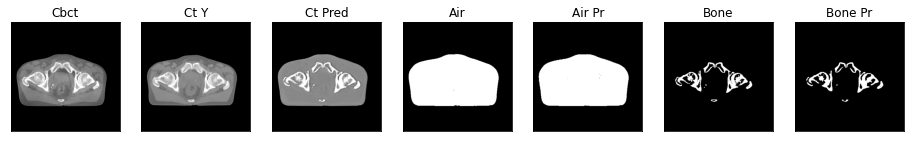

ssim score = 0.8360857367515564
psnr score = 22.74060821533203
snr score = 13.256011009216309
mae error = 0.02793719433248043
air dice score = 0.9973622806127652
bone dice score = 0.9477682811020278


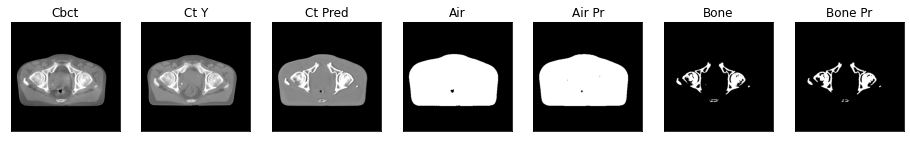

ssim score = 0.8435283303260803
psnr score = 23.06210708618164
snr score = 13.391973495483398
mae error = 0.026480266824364662
air dice score = 0.9975915418214499
bone dice score = 0.9480485462328818


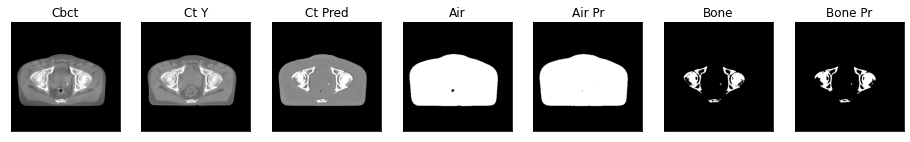

1it [00:02,  2.75s/it]

ssim score = 0.8501326441764832
psnr score = 23.371009826660156
snr score = 13.606319427490234
mae error = 0.02531079761683941
air dice score = 0.9978850971212703
bone dice score = 0.95366502088916


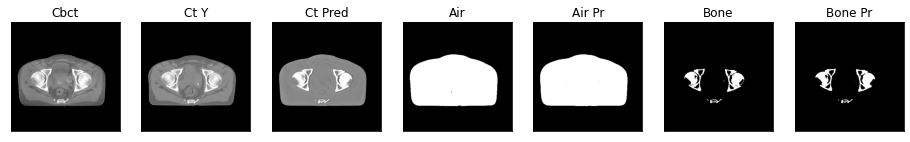

ssim score = 0.8556886315345764
psnr score = 23.624608993530273
snr score = 13.844635009765625
mae error = 0.024291854351758957
air dice score = 0.9977760537884688
bone dice score = 0.9509852460644521


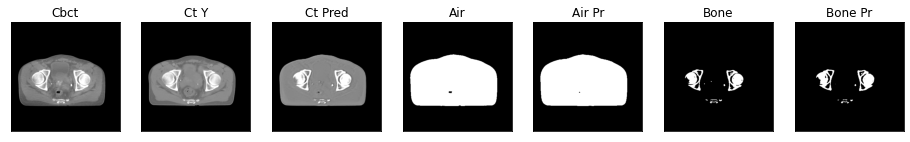

ssim score = 0.8641170263290405
psnr score = 23.89615821838379
snr score = 14.148454666137695
mae error = 0.022848831489682198
air dice score = 0.9977938268778511
bone dice score = 0.964081977604436


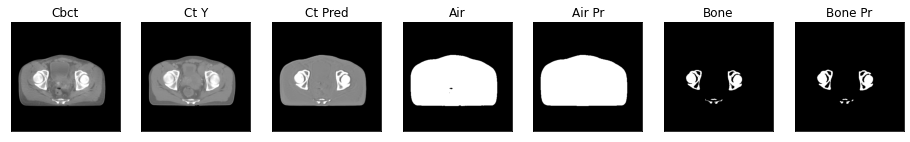

ssim score = 0.8663890957832336
psnr score = 23.775083541870117
snr score = 14.051090240478516
mae error = 0.02265321835875511
air dice score = 0.9972733684953023
bone dice score = 0.9635610326148565


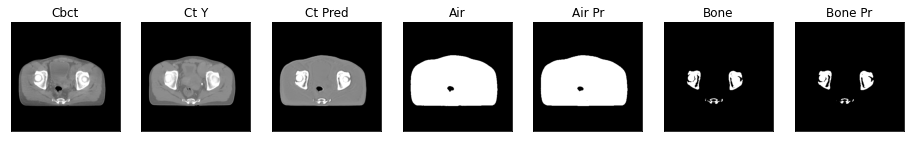

ssim score = 0.8714132308959961
psnr score = 23.473857879638672
snr score = 13.717945098876953
mae error = 0.02260192669928074
air dice score = 0.9971583955045209
bone dice score = 0.9678815489753089


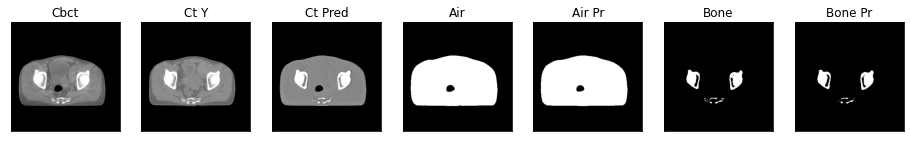

ssim score = 0.8689796924591064
psnr score = 23.329566955566406
snr score = 13.431694030761719
mae error = 0.02316465973854065
air dice score = 0.997199240253681
bone dice score = 0.9560903001741988


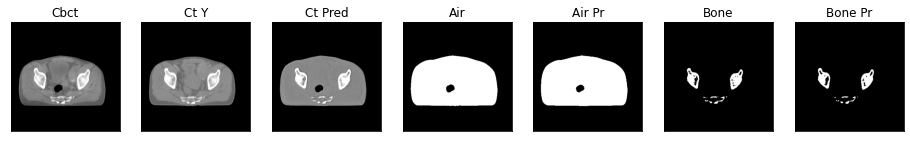

ssim score = 0.8658254742622375
psnr score = 23.242050170898438
snr score = 13.258513450622559
mae error = 0.023545721545815468
air dice score = 0.9962730503732391
bone dice score = 0.9482374524970746


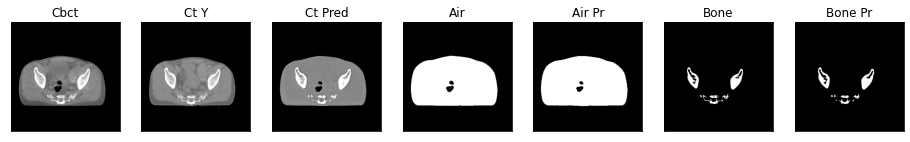

ssim score = 0.8613471388816833
psnr score = 22.87255859375
snr score = 12.912507057189941
mae error = 0.024691013619303703
air dice score = 0.9963952225841516
bone dice score = 0.9448068238842849


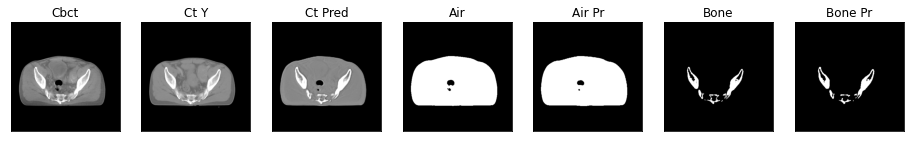

2it [00:04,  2.54s/it]

ssim score = 0.8594828844070435
psnr score = 22.402587890625
snr score = 12.439994812011719
mae error = 0.025747958570718765
air dice score = 0.9960338822909043
bone dice score = 0.9458244617938747


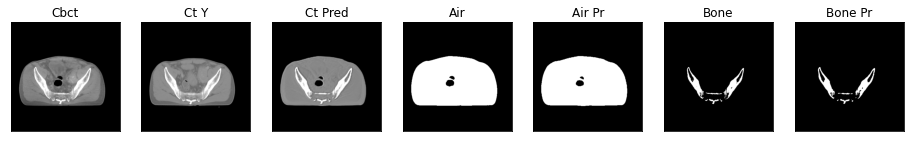

ssim score = 0.8531010150909424
psnr score = 22.02459144592285
snr score = 11.960238456726074
mae error = 0.02730727754533291
air dice score = 0.9945281046333224
bone dice score = 0.9316576900068023


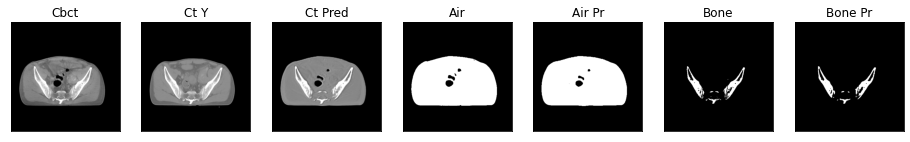

ssim score = 0.8506683707237244
psnr score = 21.858478546142578
snr score = 11.743441581726074
mae error = 0.028005102649331093
air dice score = 0.993287688118431
bone dice score = 0.9212192262611814


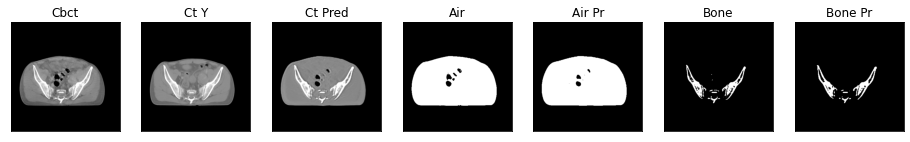

ssim score = 0.8553482890129089
psnr score = 21.702396392822266
snr score = 11.575052261352539
mae error = 0.028067881241440773
air dice score = 0.9949364519075762
bone dice score = 0.9316590195613177


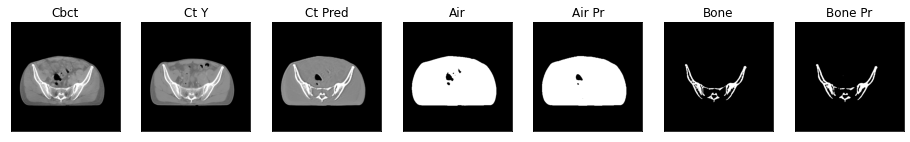

ssim score = 0.8505263328552246
psnr score = 21.446836471557617
snr score = 11.254643440246582
mae error = 0.02864779345691204
air dice score = 0.9969876436552989
bone dice score = 0.9176938369792221


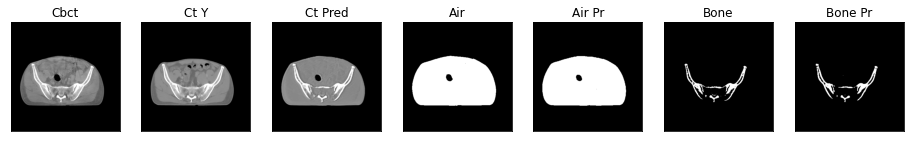

ssim score = 0.8488335013389587
psnr score = 21.49730682373047
snr score = 11.245687484741211
mae error = 0.028279006481170654
air dice score = 0.9948830912553694
bone dice score = 0.9232163666978737


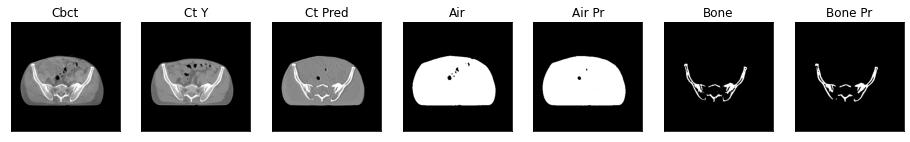

ssim score = 0.8538304567337036
psnr score = 21.49103355407715
snr score = 11.205986976623535
mae error = 0.02785654552280903
air dice score = 0.9966568338249793
bone dice score = 0.9278525524441874


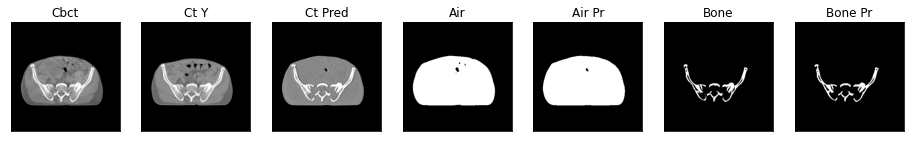

ssim score = 0.8539050817489624
psnr score = 21.327533721923828
snr score = 10.993919372558594
mae error = 0.028687451034784317
air dice score = 0.9966100109882442
bone dice score = 0.9217411709501144


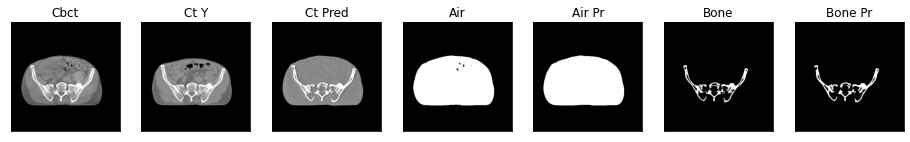

3it [00:07,  2.46s/it]

ssim score = 0.8510825634002686
psnr score = 21.220001220703125
snr score = 10.789389610290527
mae error = 0.029144562780857086
air dice score = 0.9971191122597812
bone dice score = 0.9282652831048019


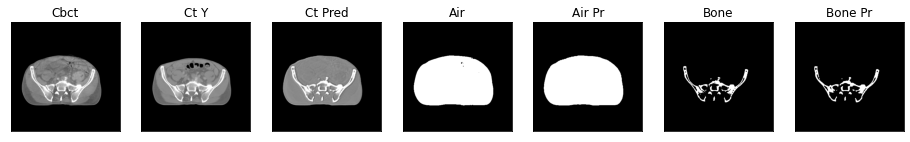

ssim score = 0.8513270020484924
psnr score = 21.362009048461914
snr score = 10.848660469055176
mae error = 0.028638077899813652
air dice score = 0.9962634678404341
bone dice score = 0.9215400157153267


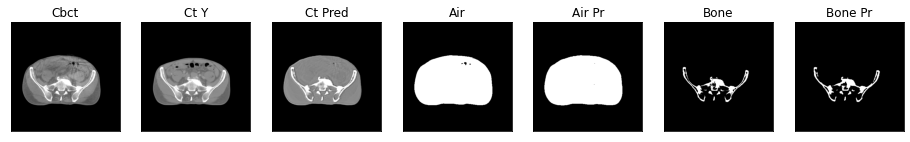

ssim score = 0.8510153293609619
psnr score = 21.36050033569336
snr score = 10.755967140197754
mae error = 0.028945565223693848
air dice score = 0.9953404664464335
bone dice score = 0.9289005924958427


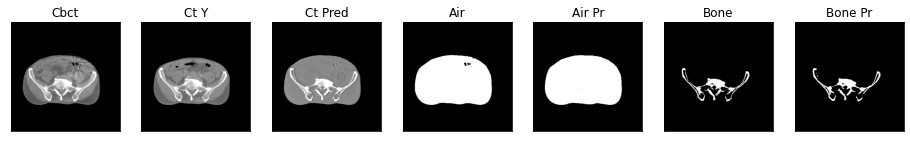

ssim score = 0.8504745364189148
psnr score = 21.221729278564453
snr score = 10.57608699798584
mae error = 0.02941633015871048
air dice score = 0.9950292361050308
bone dice score = 0.9221720407528393


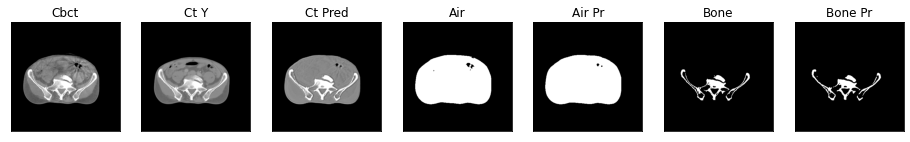

ssim score = 0.8189104199409485
psnr score = 20.528162002563477
snr score = 11.90031909942627
mae error = 0.04622301086783409
air dice score = 0.9967527813269365
bone dice score = 0.976597090449823


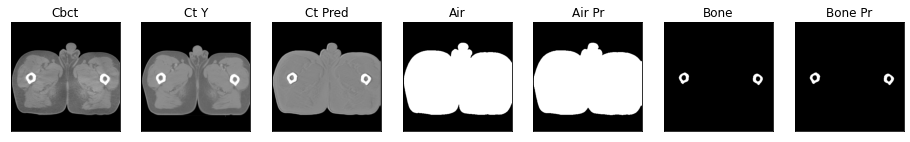

ssim score = 0.8215014934539795
psnr score = 20.780506134033203
snr score = 12.191920280456543
mae error = 0.04561971127986908
air dice score = 0.9972367322968521
bone dice score = 0.9798458802614154


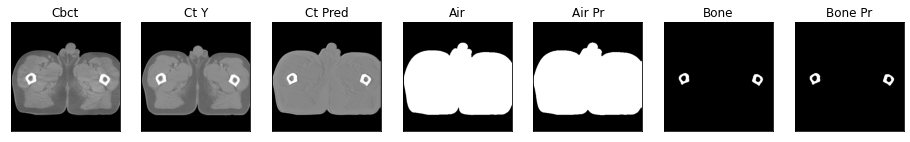

ssim score = 0.8224719166755676
psnr score = 20.942428588867188
snr score = 12.441291809082031
mae error = 0.045561522245407104
air dice score = 0.9973415848574725
bone dice score = 0.9739497770482528


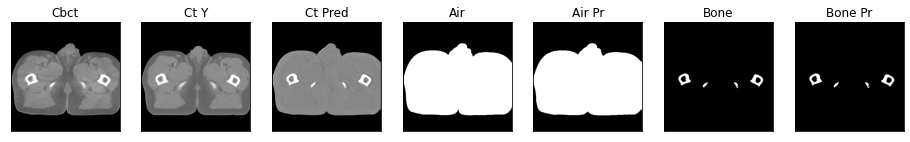

ssim score = 0.8211649656295776
psnr score = 21.040456771850586
snr score = 12.701875686645508
mae error = 0.04569599777460098
air dice score = 0.9976748301893715
bone dice score = 0.9720706260036586


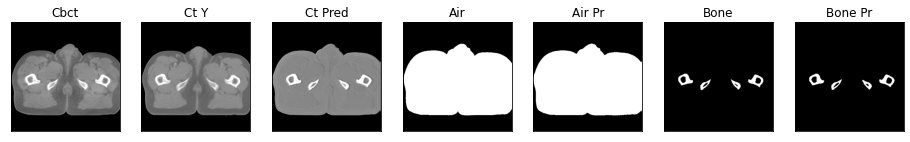

4it [00:09,  2.34s/it]

ssim score = 0.8210731744766235
psnr score = 21.294322967529297
snr score = 13.08388614654541
mae error = 0.04457619786262512
air dice score = 0.9979081024543323
bone dice score = 0.962067069819103


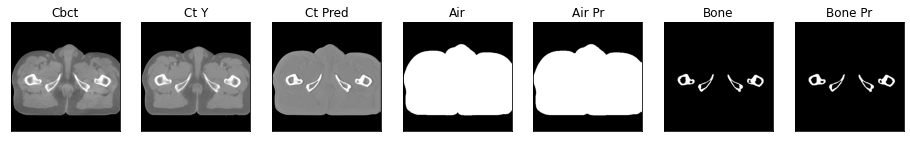

ssim score = 0.8250805735588074
psnr score = 21.45893096923828
snr score = 13.35173225402832
mae error = 0.043605271726846695
air dice score = 0.9980012840235982
bone dice score = 0.9528946422155951


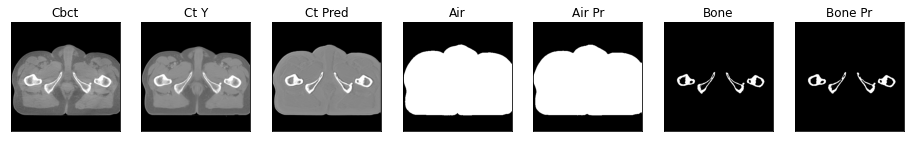

ssim score = 0.822966456413269
psnr score = 21.523962020874023
snr score = 13.483865737915039
mae error = 0.043814145028591156
air dice score = 0.9979959919839692
bone dice score = 0.9494044366741405


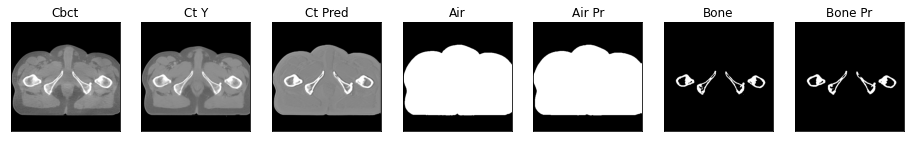

ssim score = 0.8158599138259888
psnr score = 21.39320182800293
snr score = 13.343214988708496
mae error = 0.04466496407985687
air dice score = 0.998032455459486
bone dice score = 0.9616500829191371


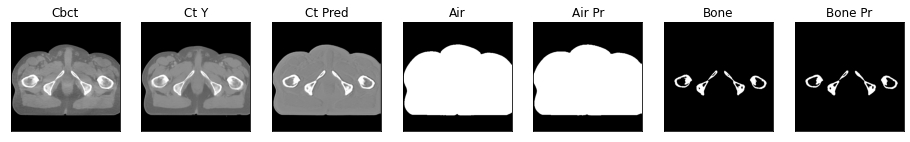

ssim score = 0.8194410800933838
psnr score = 21.448211669921875
snr score = 13.384559631347656
mae error = 0.04433242604136467
air dice score = 0.9980782858309624
bone dice score = 0.966357069143794


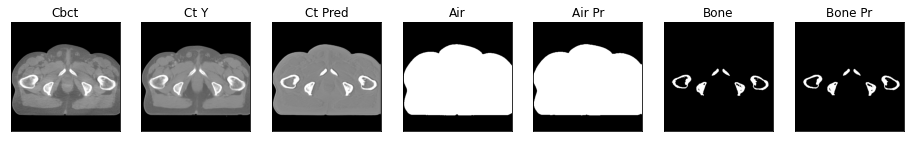

ssim score = 0.8240658640861511
psnr score = 21.53762435913086
snr score = 13.485973358154297
mae error = 0.04392210766673088
air dice score = 0.9978411571397744
bone dice score = 0.9633986928108562


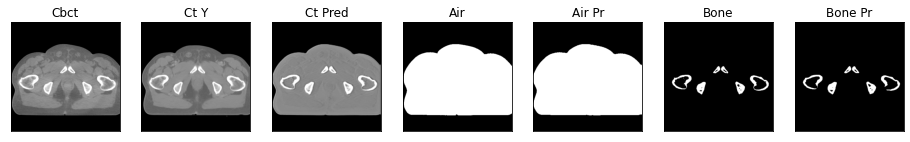

ssim score = 0.826392412185669
psnr score = 21.685588836669922
snr score = 13.673020362854004
mae error = 0.043105561286211014
air dice score = 0.9978543087637715
bone dice score = 0.9583147570223104


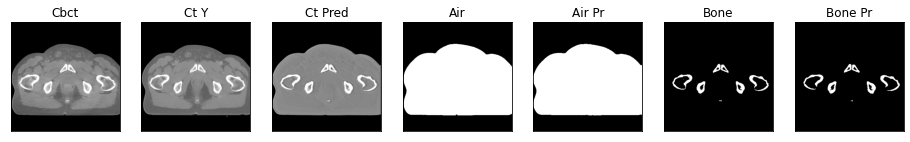

ssim score = 0.8221176266670227
psnr score = 21.787017822265625
snr score = 13.915742874145508
mae error = 0.04275421425700188
air dice score = 0.9978243540489203
bone dice score = 0.9555088791296973


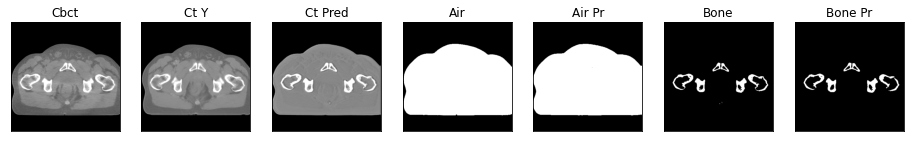

5it [00:11,  2.33s/it]

ssim score = 0.8174813985824585
psnr score = 21.825660705566406
snr score = 14.049072265625
mae error = 0.043483562767505646
air dice score = 0.9977730156729288
bone dice score = 0.9587653343889294


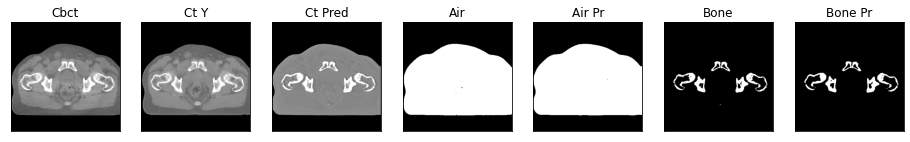

ssim score = 0.8081766366958618
psnr score = 21.632802963256836
snr score = 13.822166442871094
mae error = 0.04505068063735962
air dice score = 0.9971754985034375
bone dice score = 0.9349700877947714


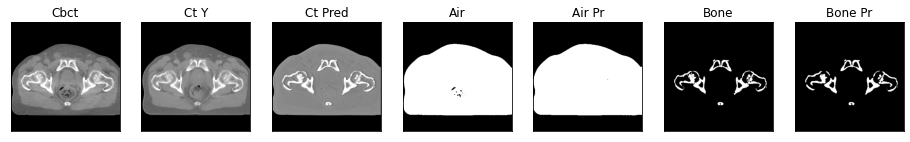

ssim score = 0.8068639039993286
psnr score = 21.59015655517578
snr score = 13.851707458496094
mae error = 0.04547927901148796
air dice score = 0.9958371961971267
bone dice score = 0.926796776127844


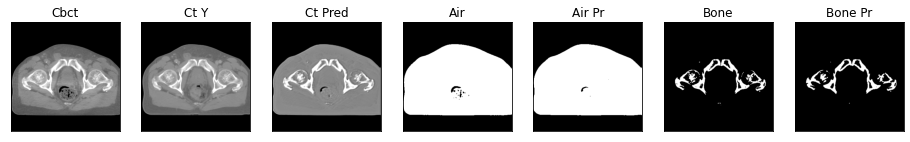

ssim score = 0.8104082345962524
psnr score = 21.607051849365234
snr score = 13.732505798339844
mae error = 0.044183652848005295
air dice score = 0.9964082773709342
bone dice score = 0.9152777777785133


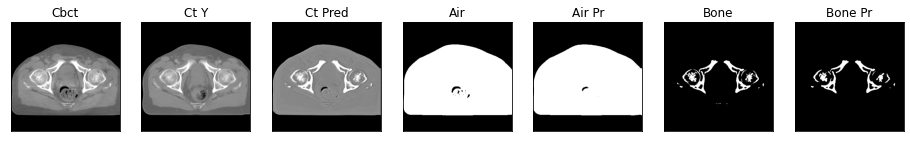

ssim score = 0.8186796307563782
psnr score = 21.57907485961914
snr score = 13.525968551635742
mae error = 0.043784018605947495
air dice score = 0.9967925264647075
bone dice score = 0.9069676917097415


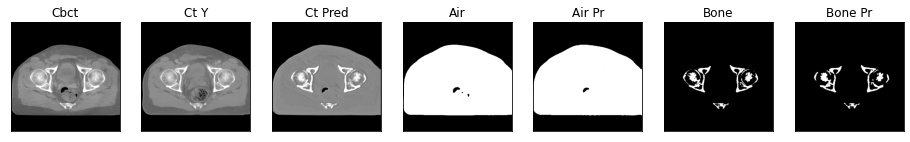

ssim score = 0.8195856809616089
psnr score = 21.561279296875
snr score = 13.417582511901855
mae error = 0.04419996961951256
air dice score = 0.9976548472597149
bone dice score = 0.9040854531449831


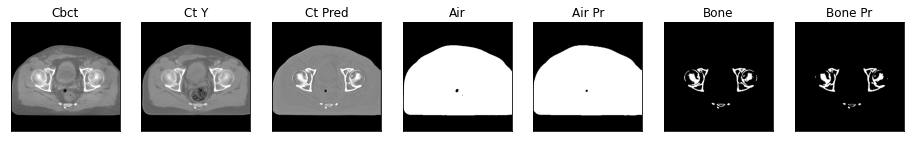

ssim score = 0.8201857805252075
psnr score = 21.48019027709961
snr score = 13.352185249328613
mae error = 0.04473656043410301
air dice score = 0.9978966217169222
bone dice score = 0.9239207719662375


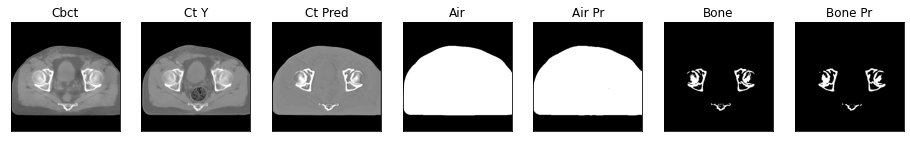

ssim score = 0.8122400045394897
psnr score = 21.338451385498047
snr score = 13.220481872558594
mae error = 0.045614395290613174
air dice score = 0.9978671203659196
bone dice score = 0.9397282757368494


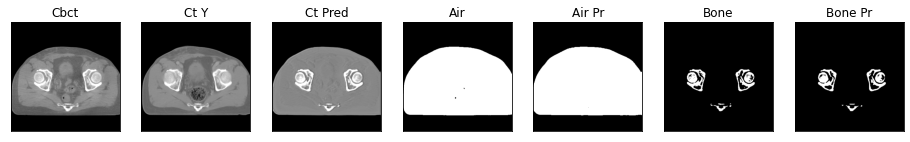

6it [00:13,  2.31s/it]

ssim score = 0.826560378074646
psnr score = 21.761314392089844
snr score = 13.704935073852539
mae error = 0.043523479253053665
air dice score = 0.9975564340020677
bone dice score = 0.9566306000182722


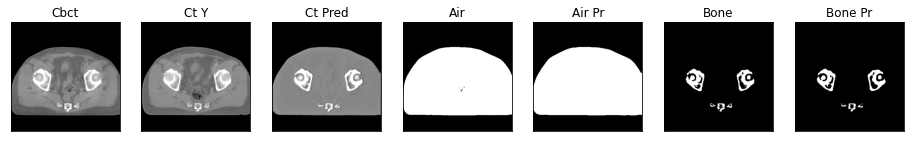

ssim score = 0.8270942568778992
psnr score = 22.06100845336914
snr score = 14.074712753295898
mae error = 0.04176274314522743
air dice score = 0.9976180728720846
bone dice score = 0.9639202081529582


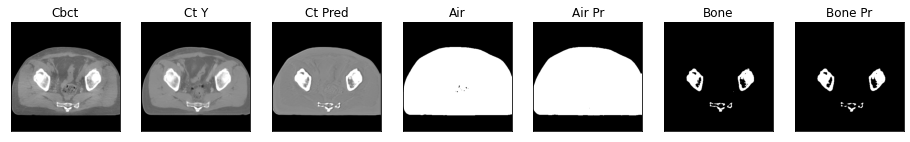

ssim score = 0.8235380053520203
psnr score = 21.749570846557617
snr score = 13.644166946411133
mae error = 0.04304545372724533
air dice score = 0.9974137449840933
bone dice score = 0.9598620557528512


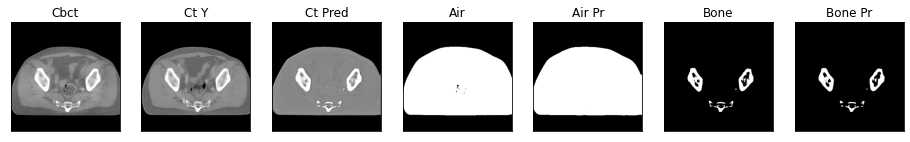

ssim score = 0.8098365664482117
psnr score = 21.182918548583984
snr score = 13.159143447875977
mae error = 0.04654661566019058
air dice score = 0.9964493081418068
bone dice score = 0.9601072745561506


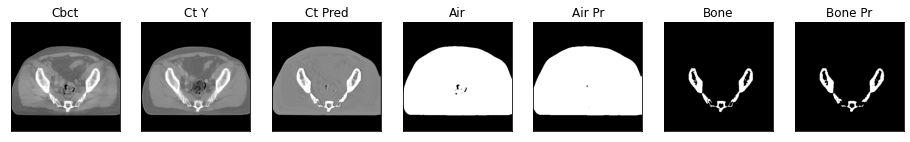

ssim score = 0.8072062134742737
psnr score = 21.23683738708496
snr score = 13.293208122253418
mae error = 0.04652180150151253
air dice score = 0.9961177672517902
bone dice score = 0.9624956672446274


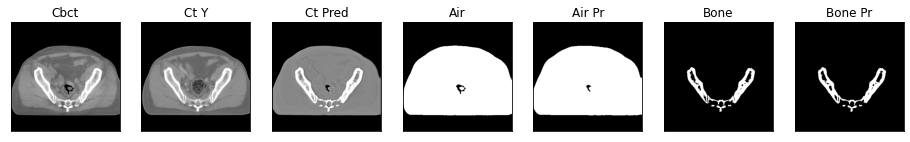

ssim score = 0.7933441400527954
psnr score = 20.9639892578125
snr score = 13.041916847229004
mae error = 0.04812576249241829
air dice score = 0.9970474143256016
bone dice score = 0.951704940849327


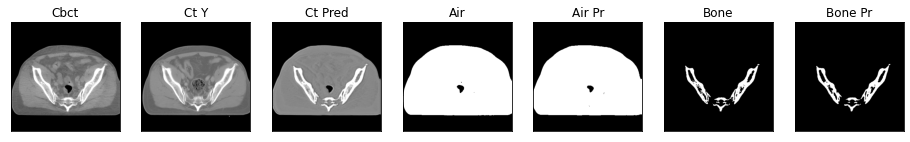

ssim score = 0.797181248664856
psnr score = 21.01736831665039
snr score = 13.107834815979004
mae error = 0.048297639936208725
air dice score = 0.9971628337347053
bone dice score = 0.9568996224267514


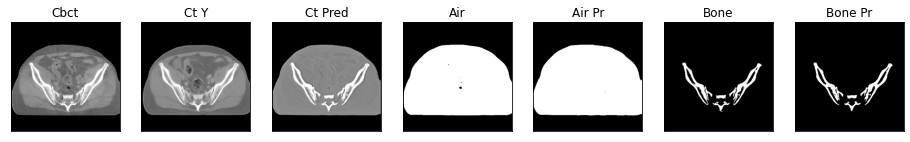

ssim score = 0.8050728440284729
psnr score = 19.517902374267578
snr score = 9.398109436035156
mae error = 0.039317112416028976
air dice score = 0.9841817658901498
bone dice score = 0.9605952052917995


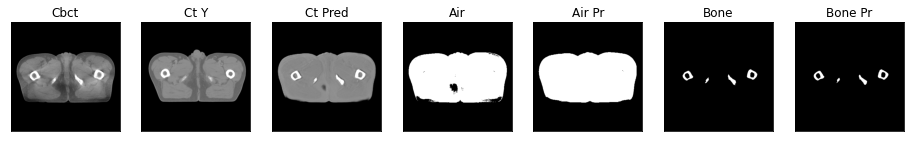

7it [00:15,  2.24s/it]

ssim score = 0.7950334548950195
psnr score = 19.237586975097656
snr score = 9.33077621459961
mae error = 0.04140118509531021
air dice score = 0.9856591081295988
bone dice score = 0.9389567147627312


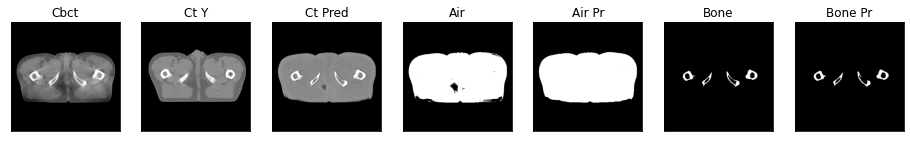

ssim score = 0.7901555895805359
psnr score = 19.23590850830078
snr score = 9.460235595703125
mae error = 0.04183053597807884
air dice score = 0.9868456129062032
bone dice score = 0.9016428419052348


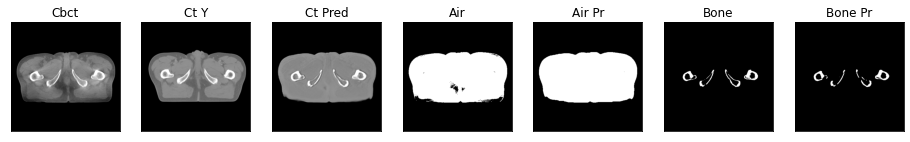

ssim score = 0.7872924208641052
psnr score = 19.32930564880371
snr score = 9.624034881591797
mae error = 0.04179440438747406
air dice score = 0.9860256304105962
bone dice score = 0.9120162932808143


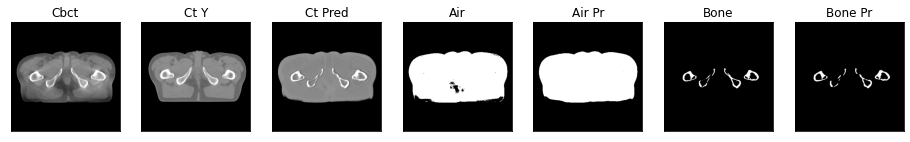

ssim score = 0.7884898781776428
psnr score = 19.352039337158203
snr score = 9.694334983825684
mae error = 0.04189058020710945
air dice score = 0.986940093180246
bone dice score = 0.9051672936071042


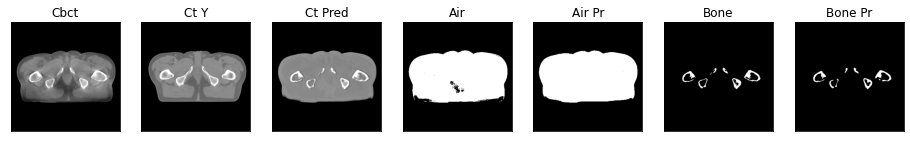

ssim score = 0.7913205027580261
psnr score = 19.487857818603516
snr score = 9.835769653320312
mae error = 0.04110198840498924
air dice score = 0.9867556937711637
bone dice score = 0.9193517635859036


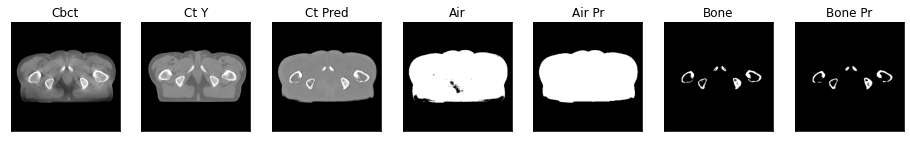

ssim score = 0.7904518842697144
psnr score = 19.57189178466797
snr score = 9.913300514221191
mae error = 0.04074844717979431
air dice score = 0.9870068337129959
bone dice score = 0.9250145320688817


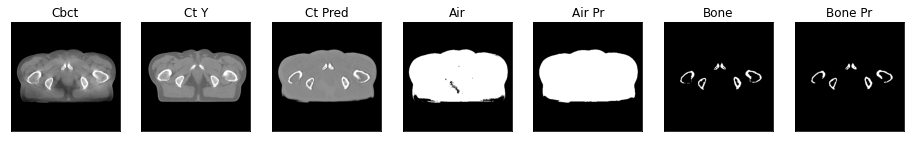

ssim score = 0.7919962406158447
psnr score = 19.533994674682617
snr score = 9.889514923095703
mae error = 0.04067613184452057
air dice score = 0.9887896843363558
bone dice score = 0.931201190034749


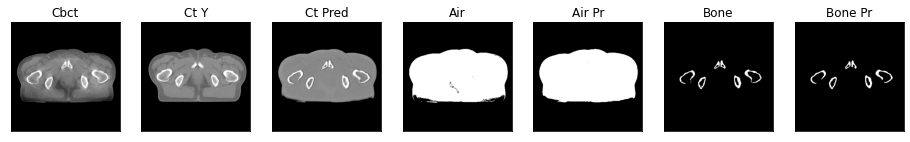

ssim score = 0.7927740216255188
psnr score = 19.587345123291016
snr score = 10.000873565673828
mae error = 0.040228355675935745
air dice score = 0.9897992344912347
bone dice score = 0.9177489177502872


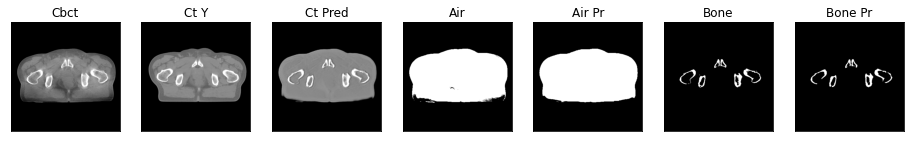

8it [00:18,  2.25s/it]

ssim score = 0.7811537384986877
psnr score = 19.381427764892578
snr score = 9.893512725830078
mae error = 0.04173072427511215
air dice score = 0.9902511611128735
bone dice score = 0.8865040650424959


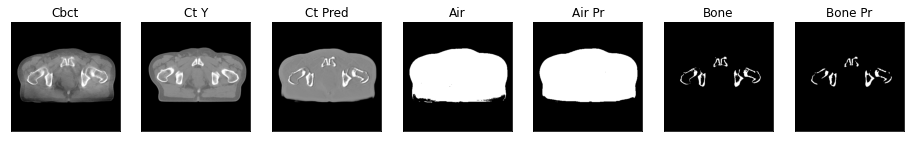

ssim score = 0.7682519555091858
psnr score = 19.171993255615234
snr score = 9.7199068069458
mae error = 0.04343947395682335
air dice score = 0.9897942653491101
bone dice score = 0.88520055325211


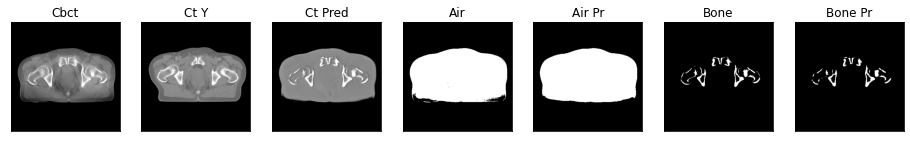

ssim score = 0.7568584084510803
psnr score = 19.04999351501465
snr score = 9.630615234375
mae error = 0.04504290968179703
air dice score = 0.9896277670513317
bone dice score = 0.8594142259433833


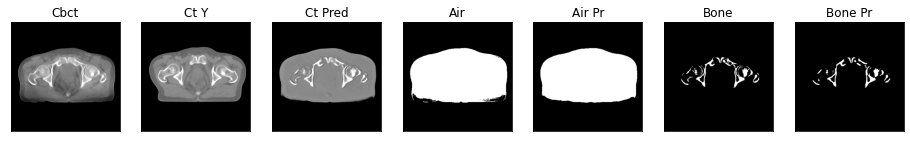

ssim score = 0.7591409683227539
psnr score = 19.18950843811035
snr score = 9.886947631835938
mae error = 0.04472772404551506
air dice score = 0.9889964038777238
bone dice score = 0.8793784925735398


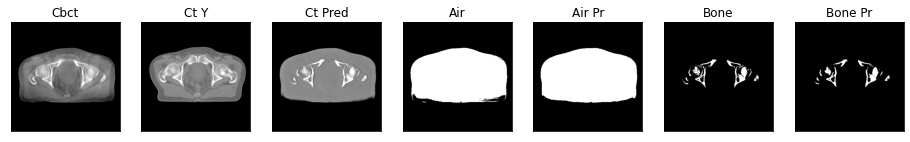

ssim score = 0.7651330232620239
psnr score = 19.29153060913086
snr score = 9.972982406616211
mae error = 0.044476356357336044
air dice score = 0.9879969521760674
bone dice score = 0.8728270814292036


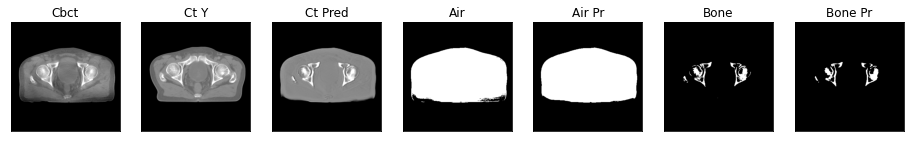

ssim score = 0.7796067595481873
psnr score = 19.736032485961914
snr score = 10.218320846557617
mae error = 0.041650377213954926
air dice score = 0.9871961436110753
bone dice score = 0.908415441771791


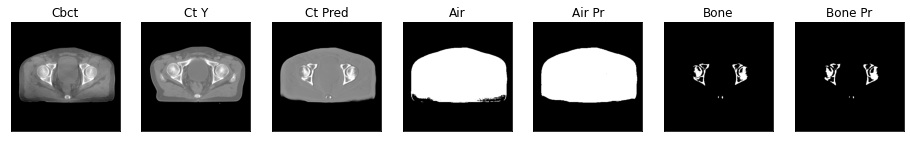

ssim score = 0.7948793172836304
psnr score = 20.190231323242188
snr score = 10.502127647399902
mae error = 0.03911659121513367
air dice score = 0.9870671150543905
bone dice score = 0.9424387414826383


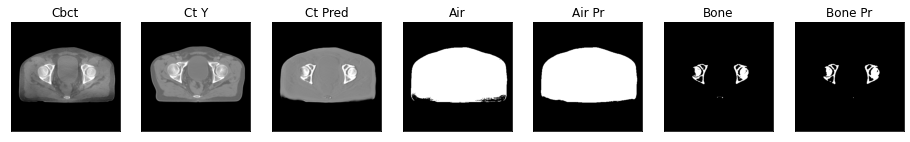

ssim score = 0.7984002828598022
psnr score = 20.445356369018555
snr score = 10.771421432495117
mae error = 0.03829486295580864
air dice score = 0.9876974320404107
bone dice score = 0.9407317402465136


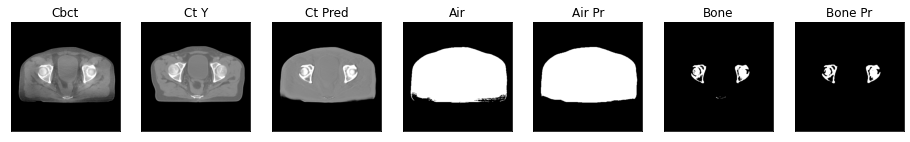

9it [00:20,  2.19s/it]

ssim score = 0.802464485168457
psnr score = 20.52604866027832
snr score = 10.933941841125488
mae error = 0.03782337158918381
air dice score = 0.9876886382181365
bone dice score = 0.9569906970479036


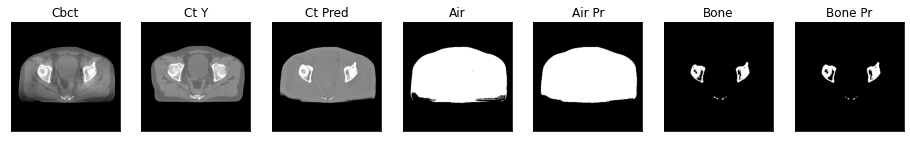

ssim score = 0.7991049289703369
psnr score = 20.482358932495117
snr score = 10.982422828674316
mae error = 0.037138212472200394
air dice score = 0.9873048273886377
bone dice score = 0.9408700980401214


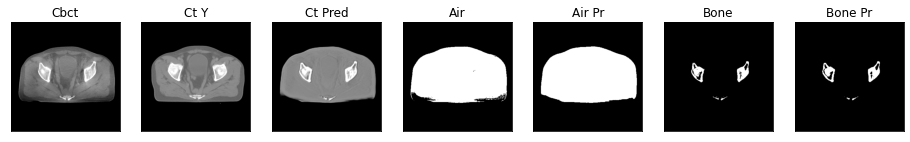

ssim score = 0.7988571524620056
psnr score = 20.703580856323242
snr score = 11.140218734741211
mae error = 0.036623984575271606
air dice score = 0.9874883452470918
bone dice score = 0.9576200764507625


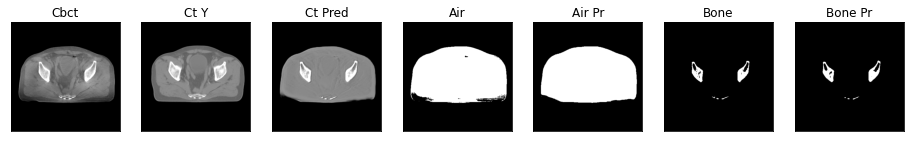

ssim score = 0.7986125349998474
psnr score = 20.85242462158203
snr score = 11.252670288085938
mae error = 0.0360909029841423
air dice score = 0.9868149578061056
bone dice score = 0.9554714259968367


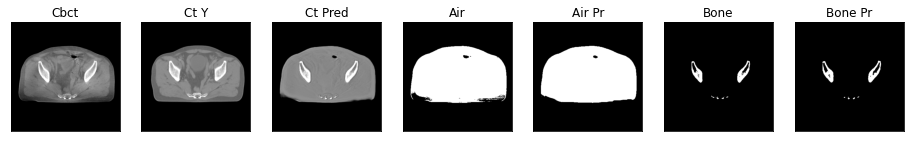

ssim score = 0.7903666496276855
psnr score = 20.710575103759766
snr score = 11.148565292358398
mae error = 0.03746582940220833
air dice score = 0.9867786124613462
bone dice score = 0.9222833562599332


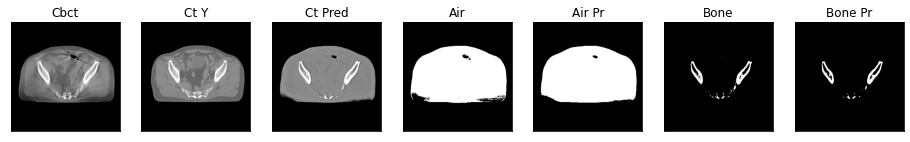

ssim score = 0.7860454320907593
psnr score = 20.635234832763672
snr score = 11.20373249053955
mae error = 0.03823958709836006
air dice score = 0.9859520093124281
bone dice score = 0.9247311827968077


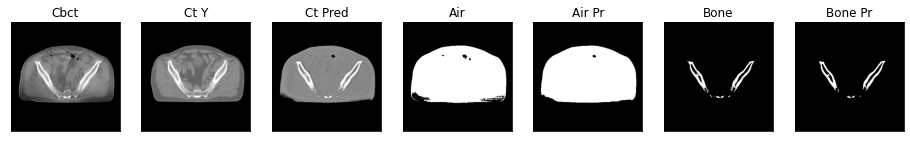

ssim score = 0.7854951024055481
psnr score = 20.538089752197266
snr score = 11.124333381652832
mae error = 0.039540164172649384
air dice score = 0.9851808675992784
bone dice score = 0.8991060025558891


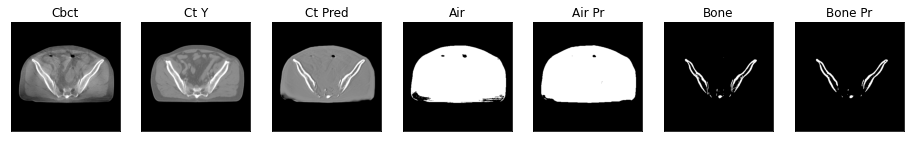

ssim score = 0.787996232509613
psnr score = 20.94292449951172
snr score = 11.517900466918945
mae error = 0.03806239739060402
air dice score = 0.9857187126477616
bone dice score = 0.9042699724534389


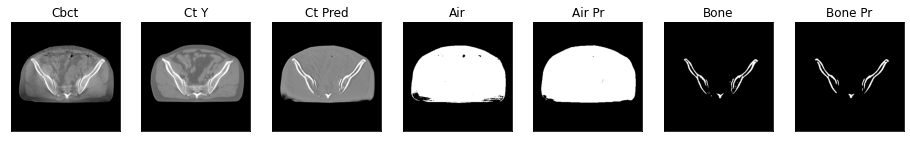

10it [00:22,  2.21s/it]

ssim score = 0.7886824607849121
psnr score = 20.98575210571289
snr score = 11.559986114501953
mae error = 0.037716079503297806
air dice score = 0.9847906720854839
bone dice score = 0.8885883347440644


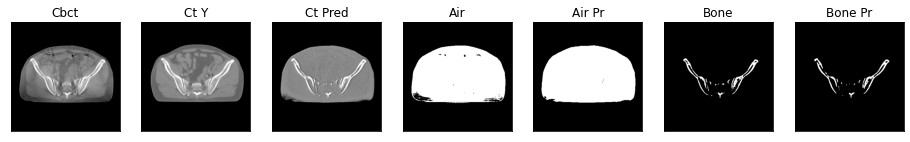

ssim score = 0.8236686587333679
psnr score = 22.00664710998535
snr score = 12.440781593322754
mae error = 0.03316161409020424
air dice score = 0.9974722673922514
bone dice score = 0.962533796834201


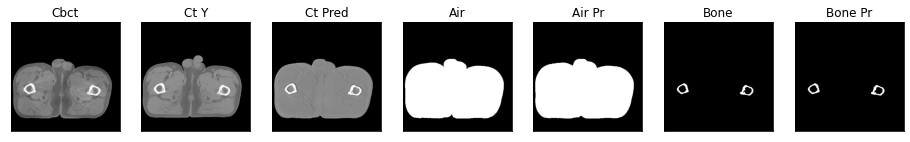

ssim score = 0.8204817771911621
psnr score = 22.140872955322266
snr score = 12.639397621154785
mae error = 0.03282877802848816
air dice score = 0.9975817558694487
bone dice score = 0.9432345590880673


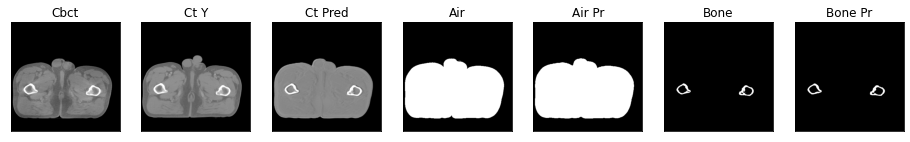

ssim score = 0.8252105712890625
psnr score = 22.90508270263672
snr score = 13.542819023132324
mae error = 0.03159595653414726
air dice score = 0.9975539283593924
bone dice score = 0.9519690416582752


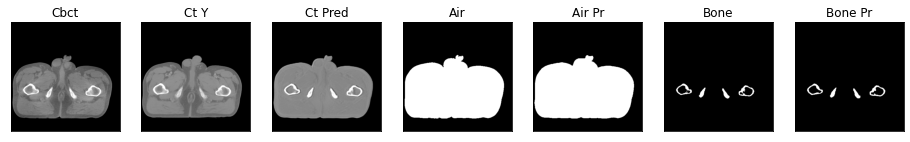

ssim score = 0.8271174430847168
psnr score = 22.783737182617188
snr score = 13.542966842651367
mae error = 0.031565699726343155
air dice score = 0.9977877673770497
bone dice score = 0.9333333333347905


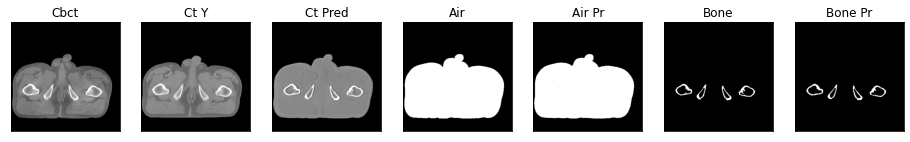

ssim score = 0.8216572999954224
psnr score = 22.525287628173828
snr score = 13.30868911743164
mae error = 0.032422855496406555
air dice score = 0.9977066742063697
bone dice score = 0.9054680259521439


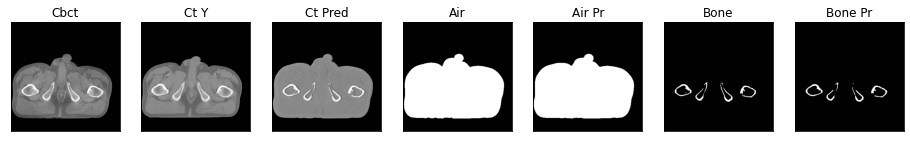

ssim score = 0.820097804069519
psnr score = 22.379762649536133
snr score = 13.158771514892578
mae error = 0.03302561119198799
air dice score = 0.9976949492732052
bone dice score = 0.9011221681155808


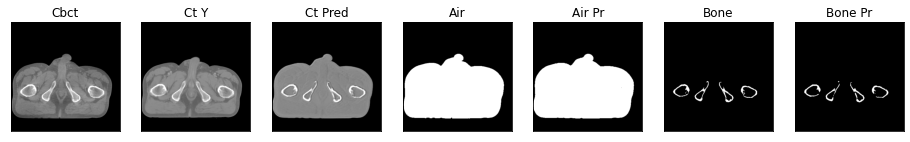

ssim score = 0.8188849687576294
psnr score = 22.082500457763672
snr score = 12.867761611938477
mae error = 0.03370918706059456
air dice score = 0.9975468104617189
bone dice score = 0.9093870902075059


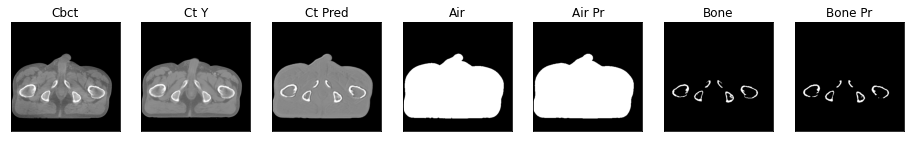

11it [00:24,  2.17s/it]

ssim score = 0.8184090852737427
psnr score = 21.931848526000977
snr score = 12.695554733276367
mae error = 0.033849071711301804
air dice score = 0.9978574287575458
bone dice score = 0.9156481667017502


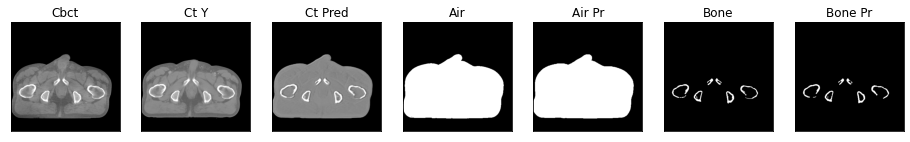

ssim score = 0.8212522268295288
psnr score = 21.989421844482422
snr score = 12.770037651062012
mae error = 0.0336461178958416
air dice score = 0.9978660241115669
bone dice score = 0.9245495495509657


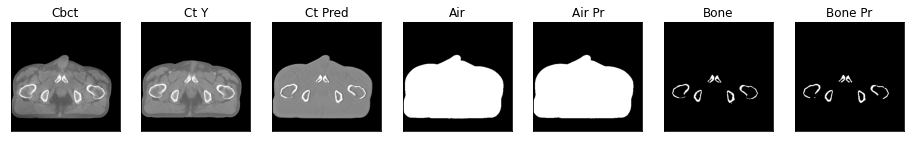

ssim score = 0.8209519386291504
psnr score = 22.286518096923828
snr score = 13.135727882385254
mae error = 0.03285836800932884
air dice score = 0.998007999620573
bone dice score = 0.9181286549721684


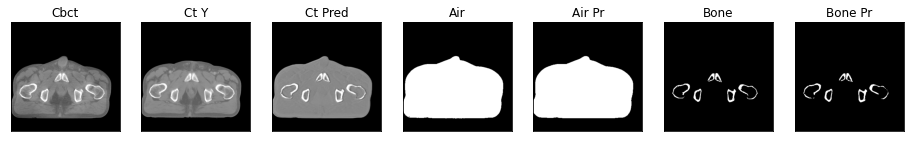

ssim score = 0.816917896270752
psnr score = 22.560136795043945
snr score = 13.490703582763672
mae error = 0.03242611140012741
air dice score = 0.9981668558005935
bone dice score = 0.9086591736598281


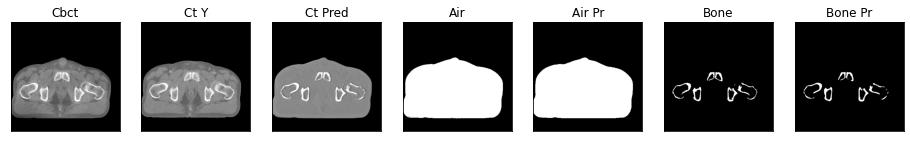

ssim score = 0.8141630291938782
psnr score = 22.771224975585938
snr score = 13.752493858337402
mae error = 0.03278599679470062
air dice score = 0.9977699549212334
bone dice score = 0.886604265768197


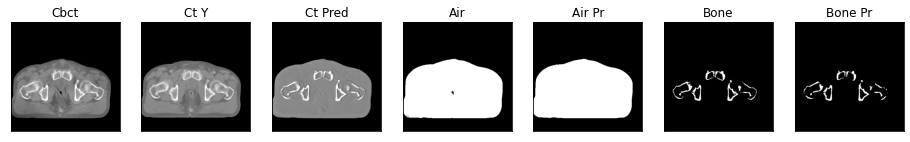

ssim score = 0.8173868060112
psnr score = 22.94373321533203
snr score = 14.041271209716797
mae error = 0.03273851424455643
air dice score = 0.9977066969244187
bone dice score = 0.868801360160544


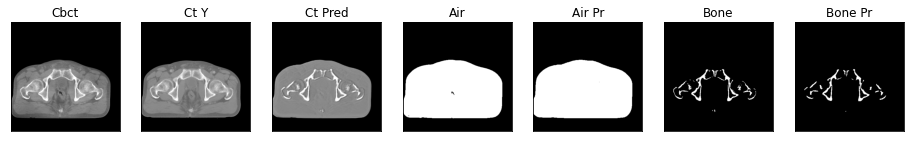

ssim score = 0.8185006976127625
psnr score = 22.866790771484375
snr score = 13.926095008850098
mae error = 0.03338227421045303
air dice score = 0.9972023924368149
bone dice score = 0.8494375096340047


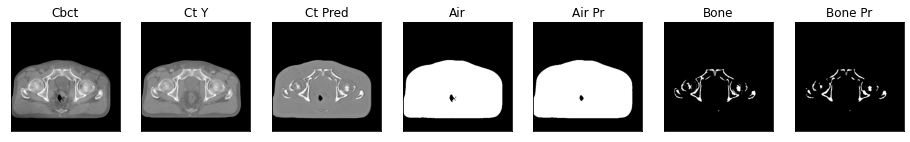

ssim score = 0.8149596452713013
psnr score = 22.614479064941406
snr score = 13.578113555908203
mae error = 0.03393986076116562
air dice score = 0.9957750476422205
bone dice score = 0.8672245467243065


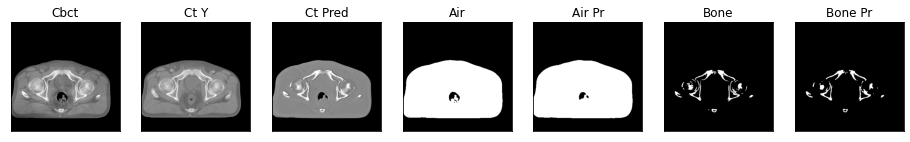

12it [00:26,  2.20s/it]

ssim score = 0.8198711276054382
psnr score = 22.704029083251953
snr score = 13.507902145385742
mae error = 0.032982200384140015
air dice score = 0.9952635275287085
bone dice score = 0.8782608695673346


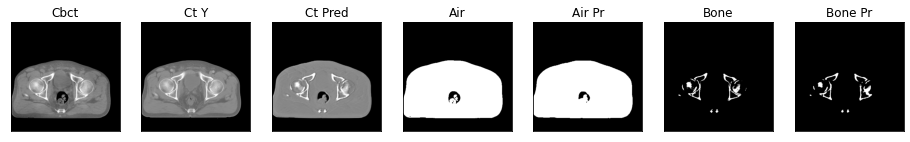

ssim score = 0.8221362829208374
psnr score = 22.35403823852539
snr score = 13.041486740112305
mae error = 0.03382835164666176
air dice score = 0.996927498884982
bone dice score = 0.8767857142879145


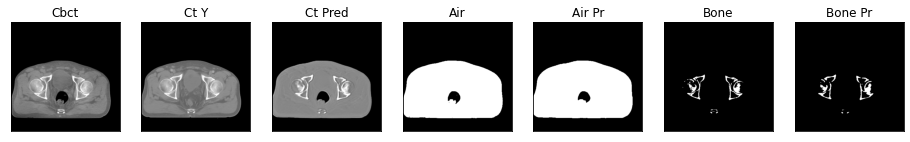

ssim score = 0.8217206597328186
psnr score = 22.219188690185547
snr score = 12.861541748046875
mae error = 0.03452504426240921
air dice score = 0.9969735769991878
bone dice score = 0.9098995223207066


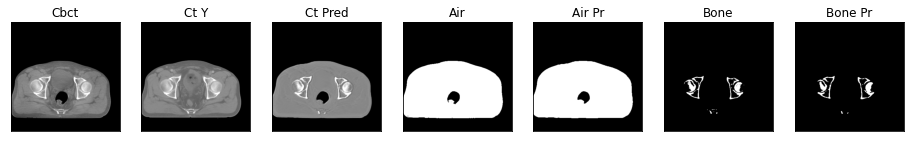

ssim score = 0.8223289847373962
psnr score = 21.805326461791992
snr score = 12.45435619354248
mae error = 0.035380881279706955
air dice score = 0.9967423453447226
bone dice score = 0.9249918113343434


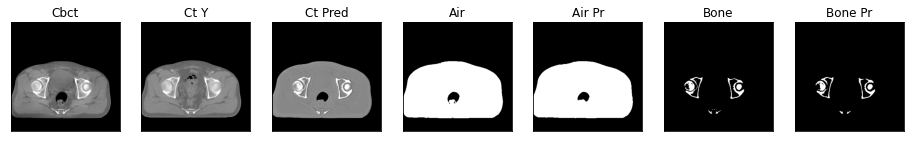

ssim score = 0.825400710105896
psnr score = 21.616539001464844
snr score = 12.295673370361328
mae error = 0.03549392893910408
air dice score = 0.9968010022969331
bone dice score = 0.9424274646826306


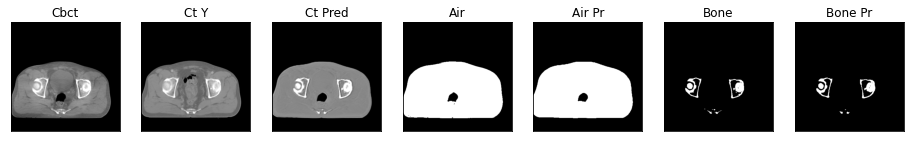

ssim score = 0.8310468792915344
psnr score = 22.147186279296875
snr score = 12.783732414245605
mae error = 0.033426929265260696
air dice score = 0.9964754993042682
bone dice score = 0.9277046658703179


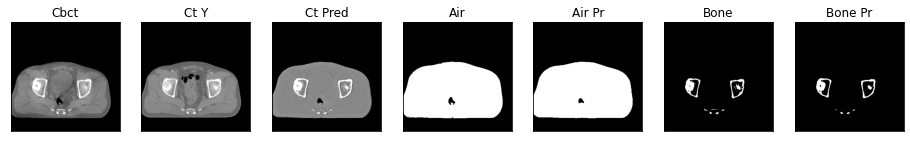

ssim score = 0.8295978307723999
psnr score = 22.183414459228516
snr score = 12.729755401611328
mae error = 0.03292342647910118
air dice score = 0.9966801301188324
bone dice score = 0.927846889953534


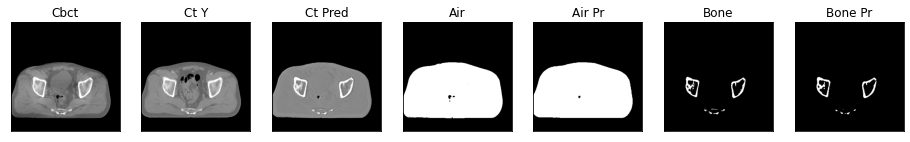

ssim score = 0.8296806812286377
psnr score = 21.905426025390625
snr score = 12.386043548583984
mae error = 0.03407255932688713
air dice score = 0.9968589039939231
bone dice score = 0.9380637402297441


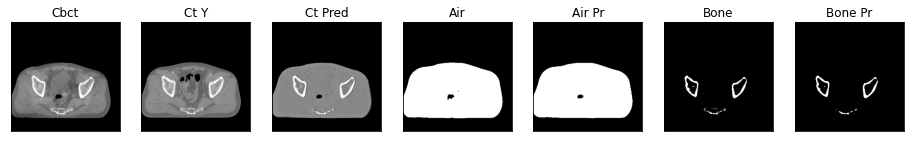

13it [00:28,  2.22s/it]

ssim score = 0.8258851766586304
psnr score = 21.88347816467285
snr score = 12.363791465759277
mae error = 0.03412729874253273
air dice score = 0.9963354979461776
bone dice score = 0.9325783047260205


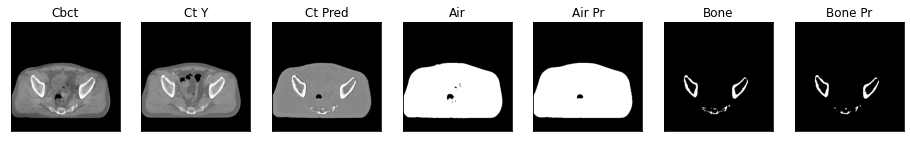

ssim score = 0.8208262324333191
psnr score = 21.8063907623291
snr score = 12.362871170043945
mae error = 0.03477192670106888
air dice score = 0.9958438384690217
bone dice score = 0.9311279053196759


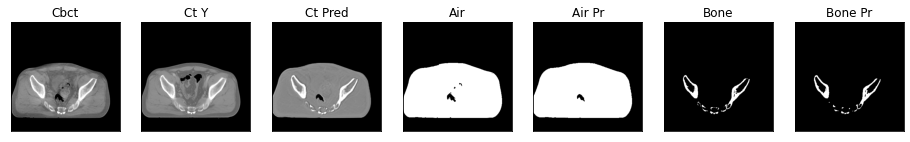

ssim score = 0.8253728747367859
psnr score = 21.750986099243164
snr score = 12.343049049377441
mae error = 0.03543786332011223
air dice score = 0.9949861207494839
bone dice score = 0.9244209133034491


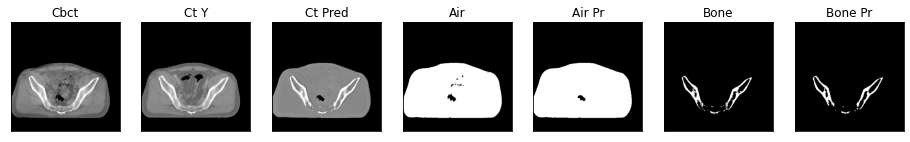

ssim score = 0.826493501663208
psnr score = 21.87679100036621
snr score = 12.40715217590332
mae error = 0.03548495098948479
air dice score = 0.9945892255012202
bone dice score = 0.899900891973667


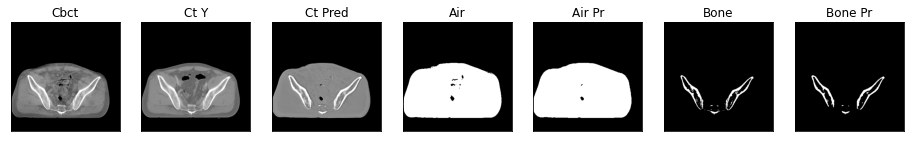

ssim score = 0.8257262110710144
psnr score = 21.810760498046875
snr score = 12.279862403869629
mae error = 0.03571217507123947
air dice score = 0.9936943196109354
bone dice score = 0.8962951941690775


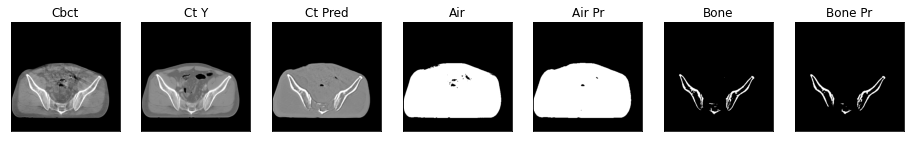

ssim score = 0.7871676683425903
psnr score = 19.860898971557617
snr score = 11.55820369720459
mae error = 0.04739288613200188
air dice score = 0.9976956324474069
bone dice score = 0.9750710003163436


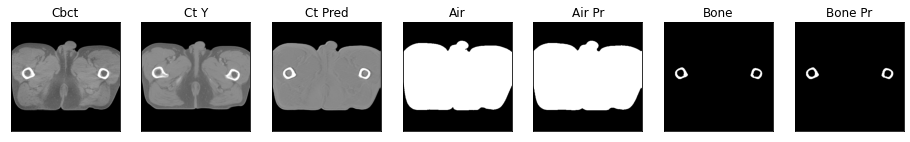

ssim score = 0.7778798937797546
psnr score = 19.638294219970703
snr score = 11.43989372253418
mae error = 0.048674046993255615
air dice score = 0.9979998219426074
bone dice score = 0.9630891538908833


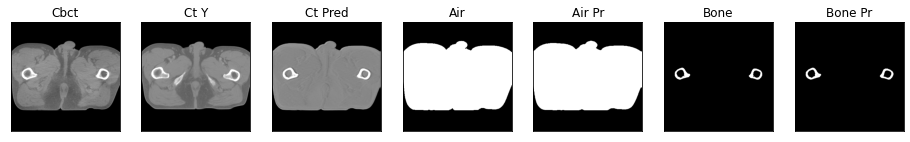

ssim score = 0.7730655670166016
psnr score = 19.52005386352539
snr score = 11.44960880279541
mae error = 0.049102433025836945
air dice score = 0.9980774122560543
bone dice score = 0.9429692911580936


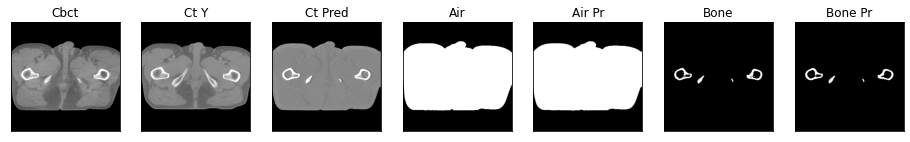

14it [00:31,  2.17s/it]

ssim score = 0.7640533447265625
psnr score = 19.201339721679688
snr score = 11.163183212280273
mae error = 0.050719063729047775
air dice score = 0.9979942659603348
bone dice score = 0.9508913555339574


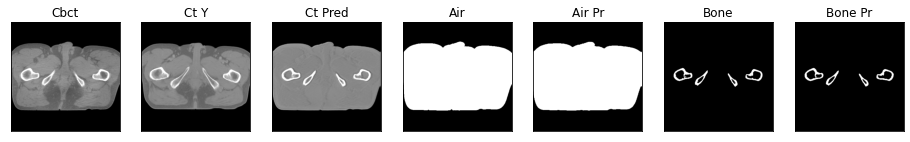

ssim score = 0.7541815638542175
psnr score = 19.074615478515625
snr score = 11.066696166992188
mae error = 0.051876988261938095
air dice score = 0.9980881790640912
bone dice score = 0.9222917352663436


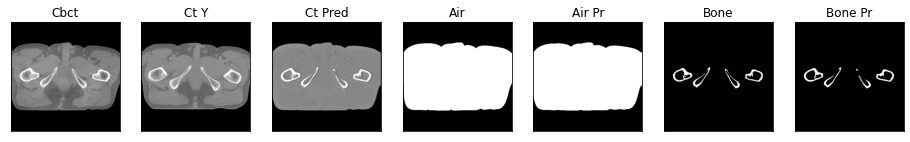

ssim score = 0.7504555583000183
psnr score = 19.01503562927246
snr score = 11.041534423828125
mae error = 0.052618496119976044
air dice score = 0.9982061413279254
bone dice score = 0.9232936756430292


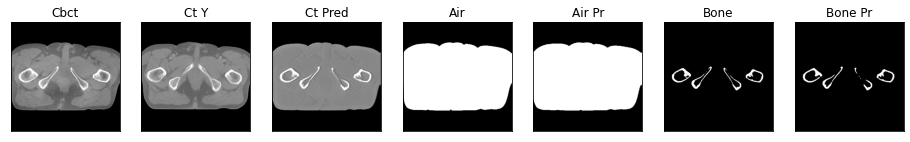

ssim score = 0.7443032264709473
psnr score = 18.808292388916016
snr score = 10.855101585388184
mae error = 0.054080501198768616
air dice score = 0.998205863961243
bone dice score = 0.9279143210225468


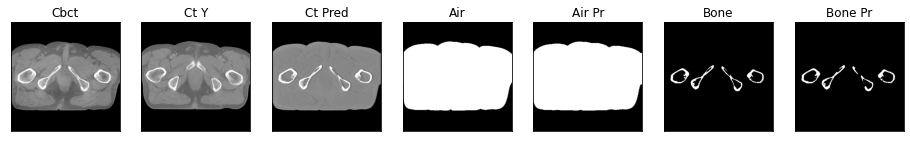

ssim score = 0.7440087795257568
psnr score = 18.845306396484375
snr score = 10.93118667602539
mae error = 0.053573090583086014
air dice score = 0.998317953510105
bone dice score = 0.9316076294287247


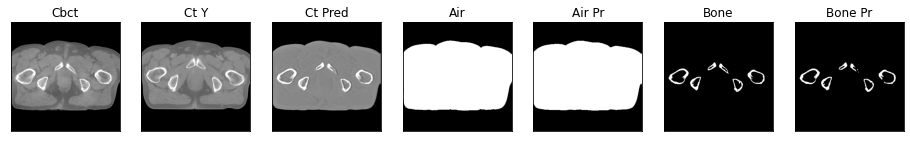

ssim score = 0.7408952116966248
psnr score = 18.91238021850586
snr score = 11.046941757202148
mae error = 0.05298609659075737
air dice score = 0.9985390540082523
bone dice score = 0.935547647292269


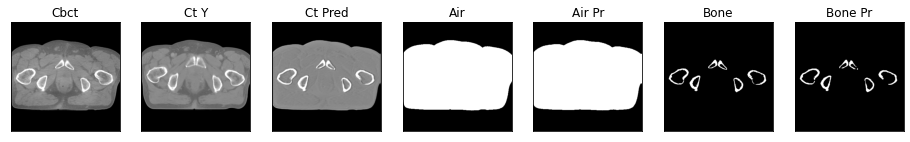

ssim score = 0.7340550422668457
psnr score = 18.866825103759766
snr score = 11.02399730682373
mae error = 0.05392233654856682
air dice score = 0.9985806986700629
bone dice score = 0.9385644001521564


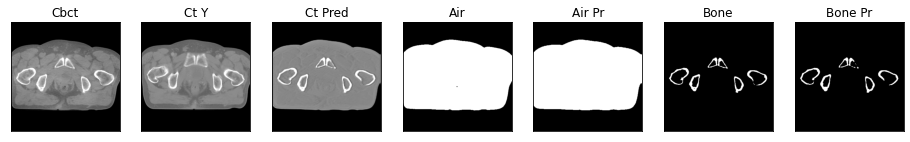

ssim score = 0.718076229095459
psnr score = 18.74191665649414
snr score = 10.94186782836914
mae error = 0.05603279545903206
air dice score = 0.9986146520914105
bone dice score = 0.9257683215138797


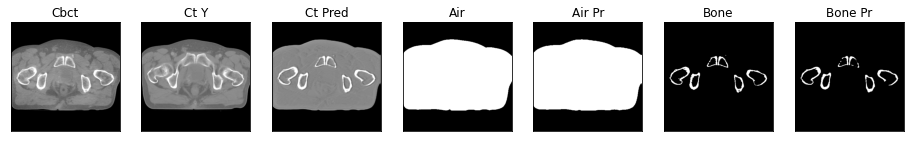

15it [00:33,  2.21s/it]

ssim score = 0.713695764541626
psnr score = 18.63235855102539
snr score = 10.890646934509277
mae error = 0.05750807002186775
air dice score = 0.9986708533817793
bone dice score = 0.9224915751720568


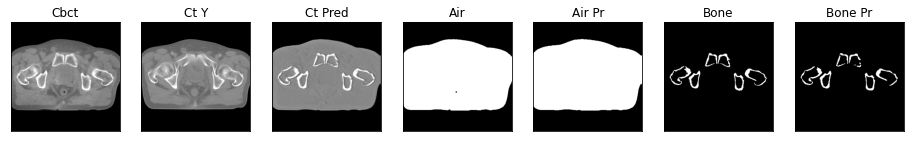

ssim score = 0.7064352631568909
psnr score = 18.370763778686523
snr score = 10.553678512573242
mae error = 0.060632143169641495
air dice score = 0.9986441542187671
bone dice score = 0.9117909117917851


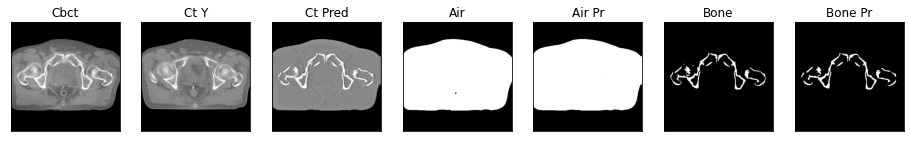

ssim score = 0.7100255489349365
psnr score = 18.24601936340332
snr score = 10.321717262268066
mae error = 0.061706919223070145
air dice score = 0.9985051797260663
bone dice score = 0.9031383184821471


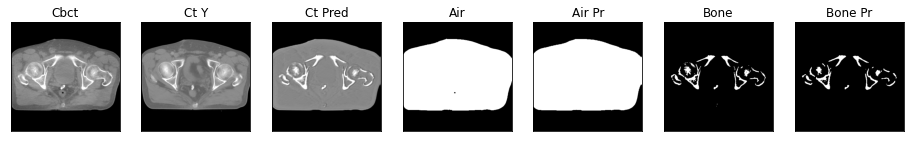

ssim score = 0.7172636985778809
psnr score = 18.360736846923828
snr score = 10.313348770141602
mae error = 0.06150903180241585
air dice score = 0.9985965807603989
bone dice score = 0.9070576073686021


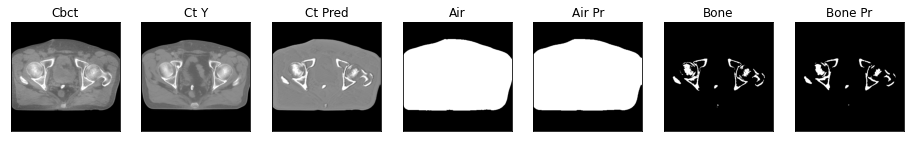

ssim score = 0.7258801460266113
psnr score = 18.42527198791504
snr score = 10.265453338623047
mae error = 0.06206635758280754
air dice score = 0.998407550766585
bone dice score = 0.9171445521068109


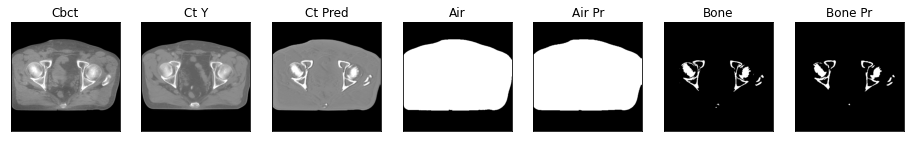

ssim score = 0.7300166487693787
psnr score = 18.40746307373047
snr score = 10.196999549865723
mae error = 0.06267724931240082
air dice score = 0.9984323917971559
bone dice score = 0.9313287281599825


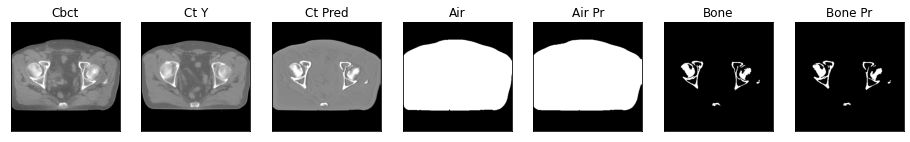

ssim score = 0.7281590700149536
psnr score = 18.36348533630371
snr score = 10.185174942016602
mae error = 0.061993811279535294
air dice score = 0.9983220986044781
bone dice score = 0.9250707906782284


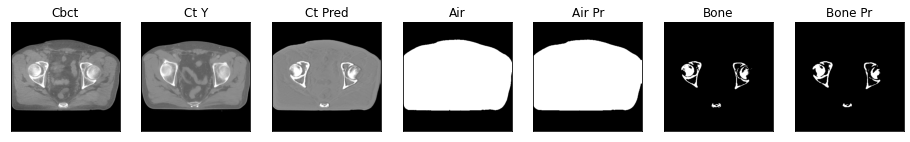

ssim score = 0.7262776494026184
psnr score = 18.332115173339844
snr score = 10.167283058166504
mae error = 0.061117786914110184
air dice score = 0.9982149987082238
bone dice score = 0.9329872581414229


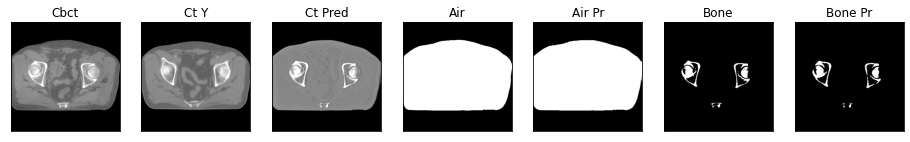

16it [00:35,  2.17s/it]

ssim score = 0.726233184337616
psnr score = 18.000988006591797
snr score = 9.694664001464844
mae error = 0.06356099992990494
air dice score = 0.9980404193030515
bone dice score = 0.9453061224496173


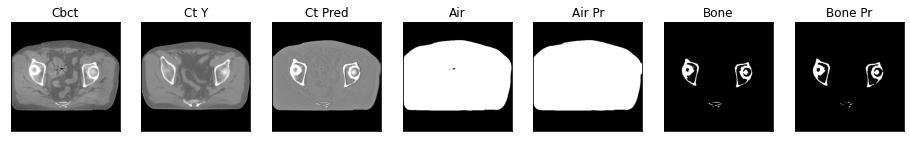

ssim score = 0.73497074842453
psnr score = 18.105226516723633
snr score = 9.739591598510742
mae error = 0.06252209097146988
air dice score = 0.9988245491136633
bone dice score = 0.9436008676797234


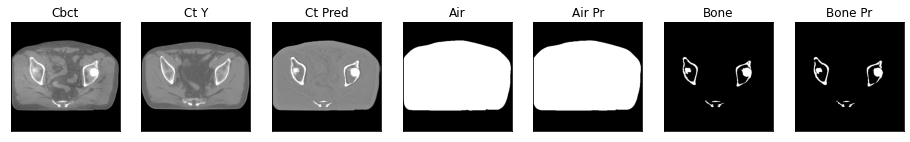

ssim score = 0.7345026731491089
psnr score = 18.359472274780273
snr score = 10.019484519958496
mae error = 0.05867546796798706
air dice score = 0.9987768715357132
bone dice score = 0.9159090909106835


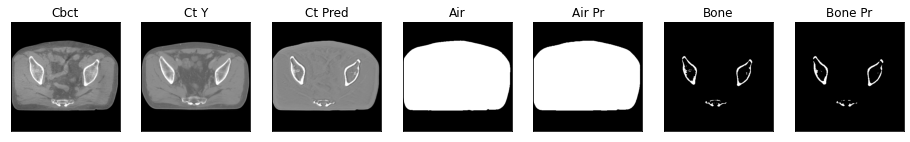

ssim score = 0.7348004579544067
psnr score = 18.48839569091797
snr score = 10.221223831176758
mae error = 0.05665900185704231
air dice score = 0.9981820908954563
bone dice score = 0.9247577092524272


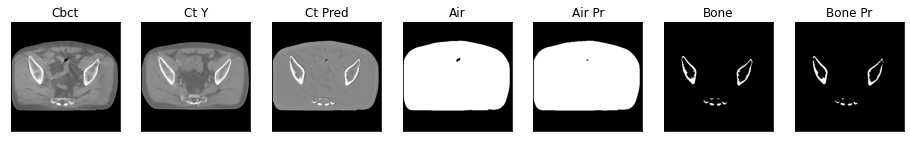

ssim score = 0.7258009910583496
psnr score = 18.390575408935547
snr score = 10.252633094787598
mae error = 0.0572868175804615
air dice score = 0.9980735202642731
bone dice score = 0.9316587832338663


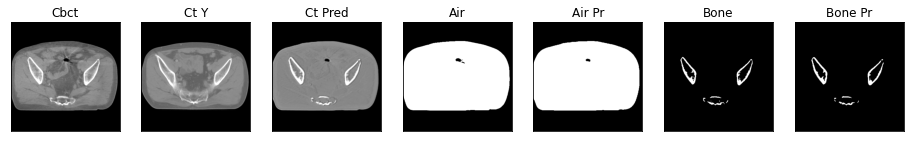

ssim score = 0.7161984443664551
psnr score = 18.287946701049805
snr score = 10.183963775634766
mae error = 0.057938385754823685
air dice score = 0.9980135950285216
bone dice score = 0.9337679656255183


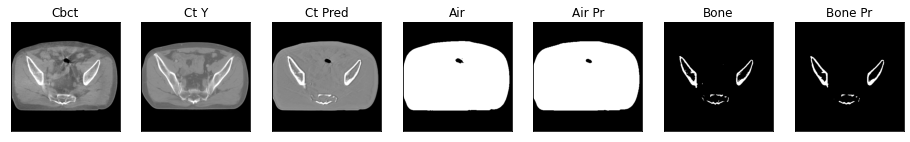

ssim score = 0.7104089856147766
psnr score = 18.207576751708984
snr score = 10.07380485534668
mae error = 0.058443862944841385
air dice score = 0.9983552230804854
bone dice score = 0.9239314175329155


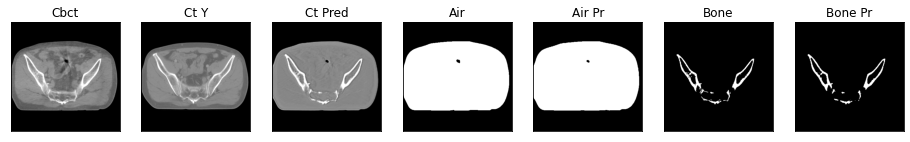

ssim score = 0.7101187109947205
psnr score = 18.228975296020508
snr score = 10.03182601928711
mae error = 0.05767447501420975
air dice score = 0.99847279746851
bone dice score = 0.9114085404727672


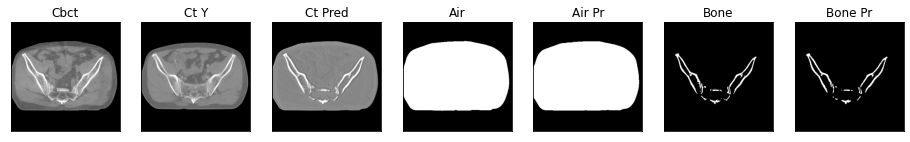

17it [00:37,  2.20s/it]

ssim score = 0.800821840763092
psnr score = 22.05980110168457
snr score = 13.537192344665527
mae error = 0.034045182168483734
air dice score = 0.9964073116469271
bone dice score = 0.897080653143282


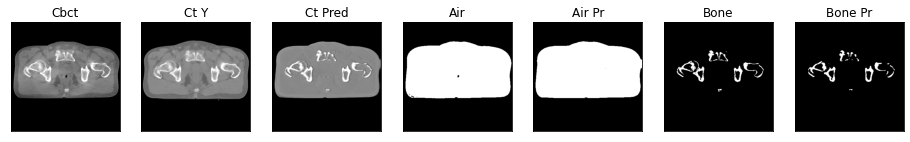

ssim score = 0.8026605248451233
psnr score = 22.24295425415039
snr score = 13.760356903076172
mae error = 0.03371742367744446
air dice score = 0.9965154172091755
bone dice score = 0.8880288957702782


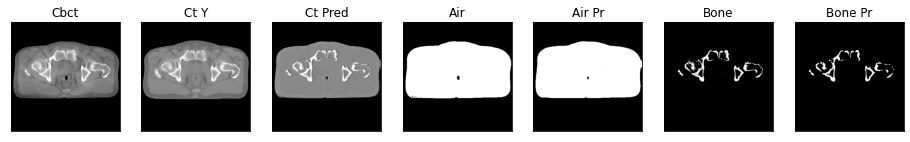

ssim score = 0.8036946654319763
psnr score = 22.302902221679688
snr score = 13.82809066772461
mae error = 0.03371134027838707
air dice score = 0.9967074778677741
bone dice score = 0.8744236506661999


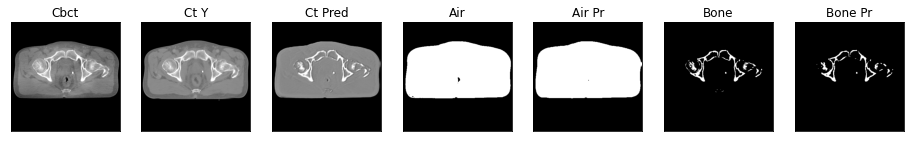

ssim score = 0.8060479164123535
psnr score = 22.472496032714844
snr score = 13.939266204833984
mae error = 0.03280152752995491
air dice score = 0.9974071134293402
bone dice score = 0.8880211613567449


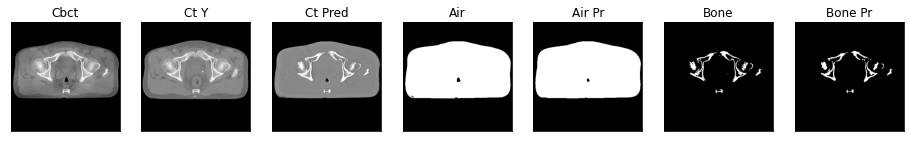

ssim score = 0.8166160583496094
psnr score = 22.74371910095215
snr score = 14.054864883422852
mae error = 0.03147640824317932
air dice score = 0.9973473996938161
bone dice score = 0.8745454545473553


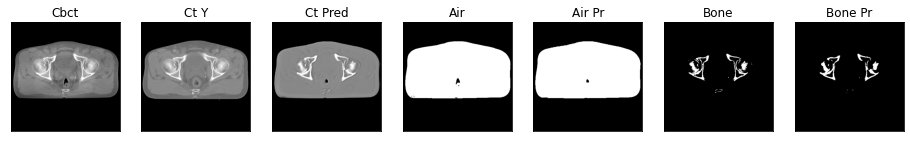

ssim score = 0.8205170631408691
psnr score = 22.859092712402344
snr score = 14.149435043334961
mae error = 0.031004909425973892
air dice score = 0.9975684260117645
bone dice score = 0.8974578691816987


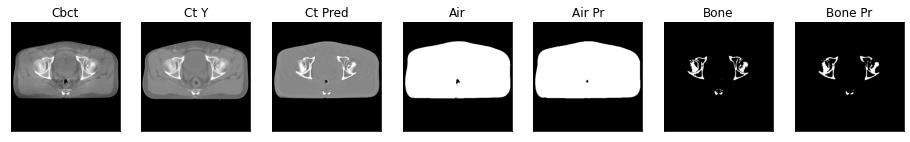

ssim score = 0.8217191696166992
psnr score = 22.948856353759766
snr score = 14.223567962646484
mae error = 0.030754506587982178
air dice score = 0.9970954831332212
bone dice score = 0.9021241149534621


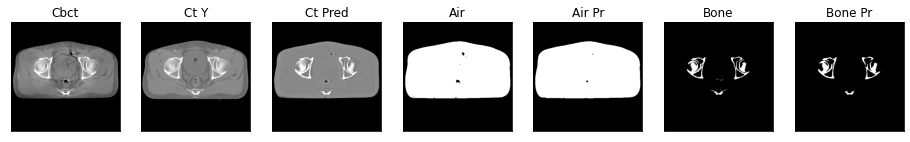

ssim score = 0.8174587488174438
psnr score = 22.462892532348633
snr score = 13.746971130371094
mae error = 0.03175726905465126
air dice score = 0.996754588735976
bone dice score = 0.9183758894946508


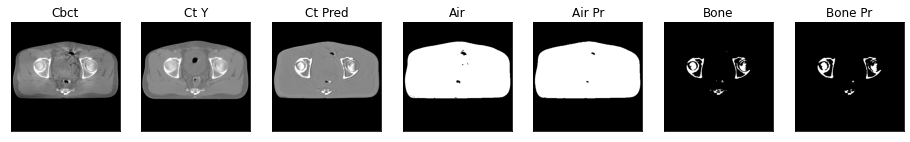

18it [00:39,  2.16s/it]

ssim score = 0.8172880411148071
psnr score = 22.65591049194336
snr score = 13.995769500732422
mae error = 0.030642585828900337
air dice score = 0.9951549866781366
bone dice score = 0.9359512525397975


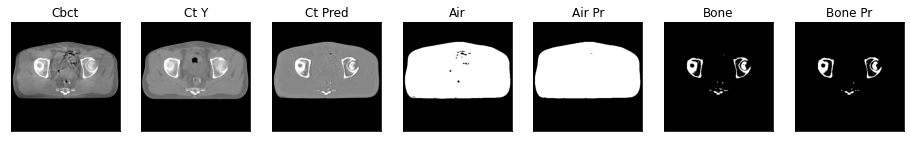

ssim score = 0.8158252835273743
psnr score = 22.197166442871094
snr score = 13.515094757080078
mae error = 0.03146441653370857
air dice score = 0.9940808309988547
bone dice score = 0.9314198978897279


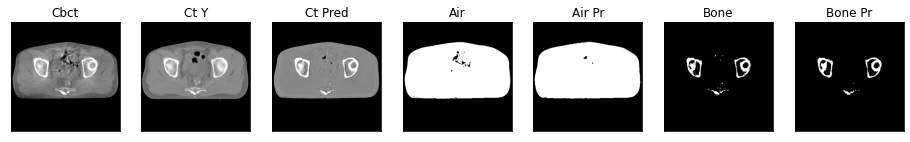

ssim score = 0.8187633156776428
psnr score = 21.83623504638672
snr score = 13.083391189575195
mae error = 0.032113540917634964
air dice score = 0.9942086436767416
bone dice score = 0.9155060352845016


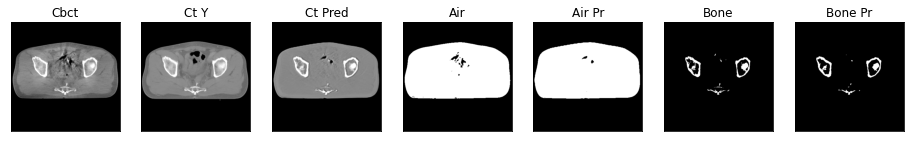

ssim score = 0.8175436854362488
psnr score = 22.15703582763672
snr score = 13.360295295715332
mae error = 0.03128160908818245
air dice score = 0.9950957641016158
bone dice score = 0.9210918114156974


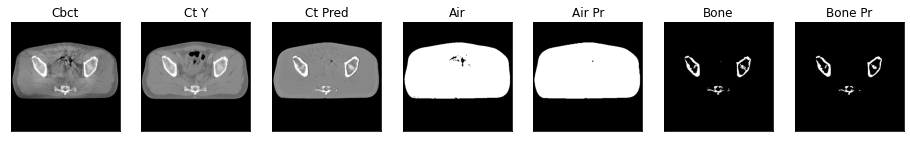

ssim score = 0.8166436553001404
psnr score = 22.445945739746094
snr score = 13.648109436035156
mae error = 0.030473722144961357
air dice score = 0.9952419023076423
bone dice score = 0.9311611563658975


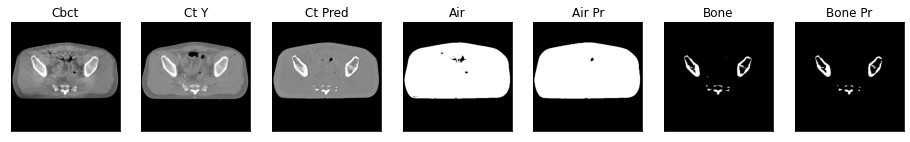

ssim score = 0.8132041692733765
psnr score = 22.575923919677734
snr score = 13.791444778442383
mae error = 0.03089386224746704
air dice score = 0.993776986562356
bone dice score = 0.9331906436334935


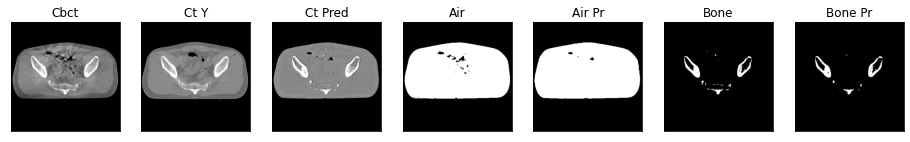

ssim score = 0.8117371201515198
psnr score = 22.513050079345703
snr score = 13.783775329589844
mae error = 0.03132001683115959
air dice score = 0.9941705830201604
bone dice score = 0.9345200254299488


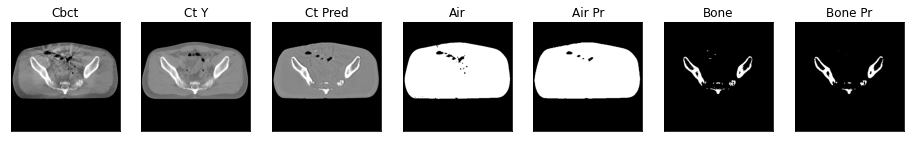

ssim score = 0.8107537031173706
psnr score = 22.031471252441406
snr score = 13.321566581726074
mae error = 0.03309503197669983
air dice score = 0.9952648386741586
bone dice score = 0.9181877872630573


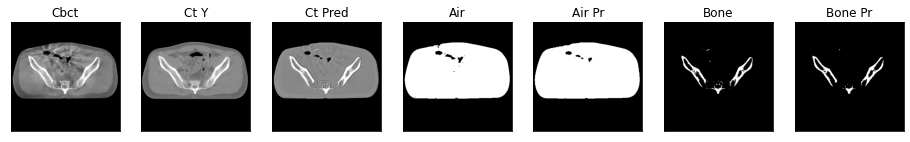

19it [00:42,  2.19s/it]

ssim score = 0.8144170641899109
psnr score = 21.783668518066406
snr score = 13.019025802612305
mae error = 0.03419085592031479
air dice score = 0.9951418913607459
bone dice score = 0.9102894812279981


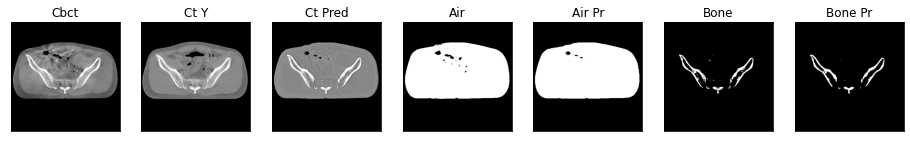

ssim score = 0.8136786818504333
psnr score = 21.615432739257812
snr score = 12.81443977355957
mae error = 0.034896932542324066
air dice score = 0.9961442717699472
bone dice score = 0.9006565800756401


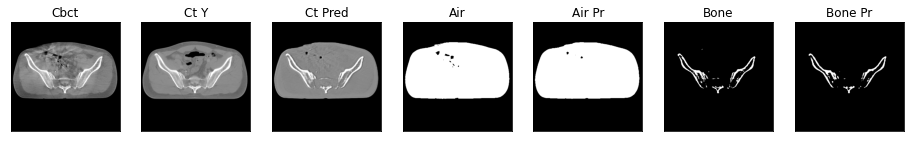

ssim score = 0.8170249462127686
psnr score = 21.621715545654297
snr score = 12.820792198181152
mae error = 0.03518861159682274
air dice score = 0.9958479518393841
bone dice score = 0.8954954954968405


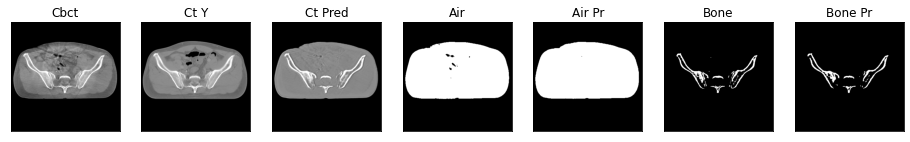

ssim score = 0.812260627746582
psnr score = 21.73220443725586
snr score = 12.92986011505127
mae error = 0.03597183898091316
air dice score = 0.9962873818176127
bone dice score = 0.8926657079370811


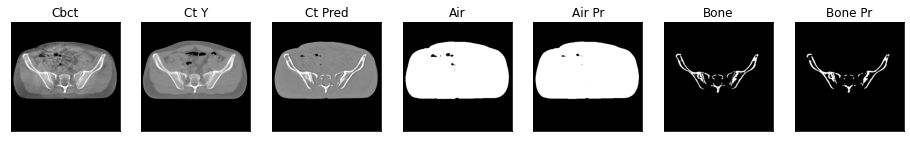

ssim score = 0.8054783344268799
psnr score = 21.498390197753906
snr score = 12.701080322265625
mae error = 0.03710826113820076
air dice score = 0.9946857305538903
bone dice score = 0.8869791666681383


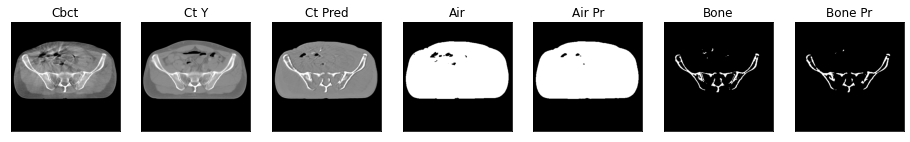

ssim score = 0.7991724610328674
psnr score = 21.147977828979492
snr score = 12.33340072631836
mae error = 0.0389736033976078
air dice score = 0.9931049839752566
bone dice score = 0.8876769250761242


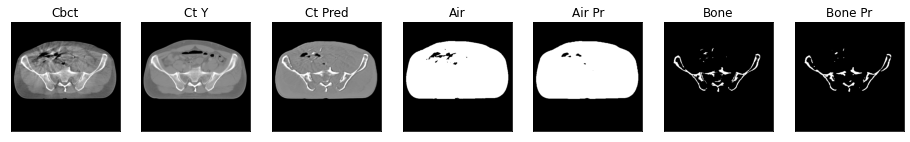

ssim score = 0.7939369082450867
psnr score = 20.889785766601562
snr score = 12.056581497192383
mae error = 0.04050106555223465
air dice score = 0.9933127982507993
bone dice score = 0.8889704084141725


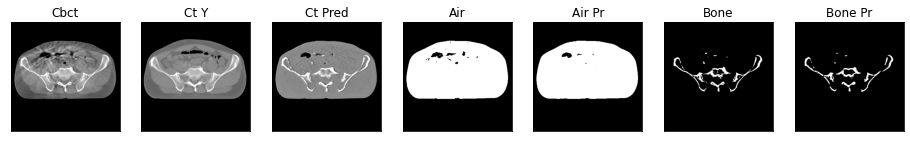

ssim score = 0.7893775105476379
psnr score = 20.508222579956055
snr score = 11.629081726074219
mae error = 0.042625848203897476
air dice score = 0.9941993686605716
bone dice score = 0.8739213806343009


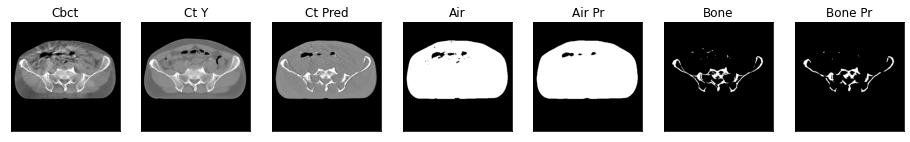

20it [00:44,  2.21s/it]

ssim score = 0.7843354344367981
psnr score = 20.513498306274414
snr score = 11.580560684204102
mae error = 0.043720219284296036
air dice score = 0.9935610572744007
bone dice score = 0.8875073313796186


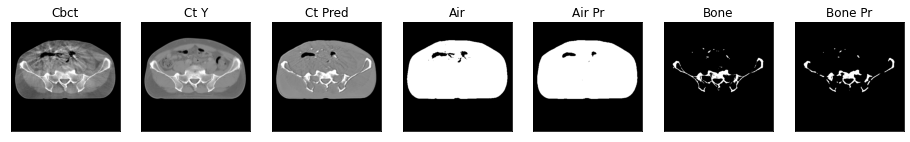

ssim score = 0.7804824709892273
psnr score = 20.26830291748047
snr score = 11.365824699401855
mae error = 0.045285191386938095
air dice score = 0.9938660222892152
bone dice score = 0.8958092150972932


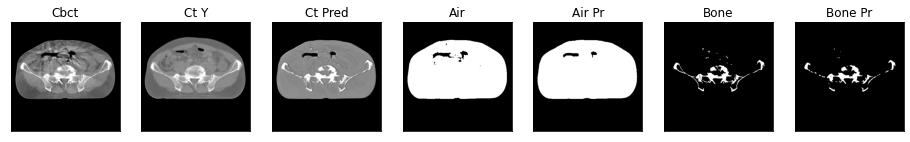

ssim score = 0.7770453095436096
psnr score = 19.963375091552734
snr score = 11.0056734085083
mae error = 0.04651302844285965
air dice score = 0.9938387052375104
bone dice score = 0.8831200487521861


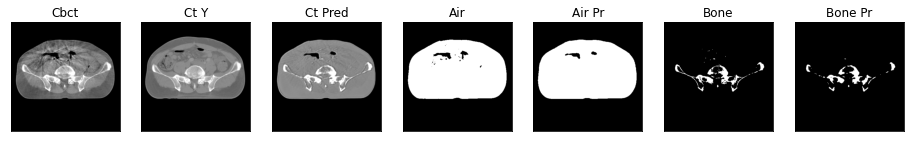

ssim score = 0.785144031047821
psnr score = 20.40249252319336
snr score = 11.297260284423828
mae error = 0.044889166951179504
air dice score = 0.9952638865275826
bone dice score = 0.9021103483358491


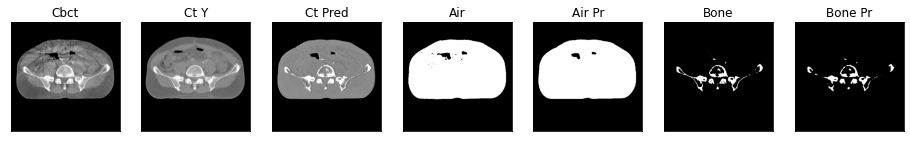

ssim score = 0.8190506100654602
psnr score = 21.382156372070312
snr score = 11.763068199157715
mae error = 0.04558466747403145
air dice score = 0.9987367036187097
bone dice score = 0.9436038514458431


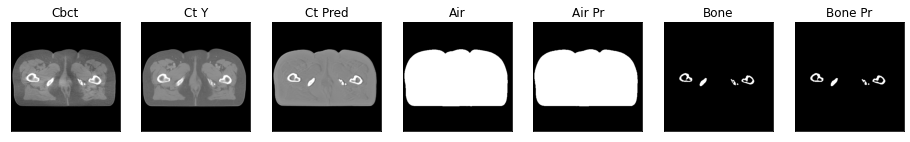

ssim score = 0.8188424110412598
psnr score = 21.43365478515625
snr score = 11.935579299926758
mae error = 0.04518882557749748
air dice score = 0.9985437903058051
bone dice score = 0.9461022438134142


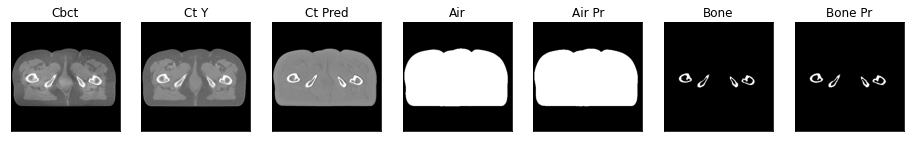

ssim score = 0.8132510781288147
psnr score = 21.426008224487305
snr score = 12.010848999023438
mae error = 0.045185718685388565
air dice score = 0.9984491773254967
bone dice score = 0.9305760709024989


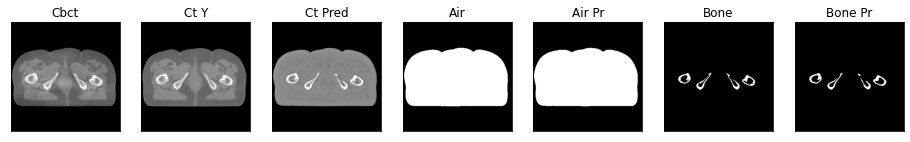

ssim score = 0.8098709583282471
psnr score = 21.383270263671875
snr score = 12.031559944152832
mae error = 0.04527446627616882
air dice score = 0.9983173023932528
bone dice score = 0.9354477611952342


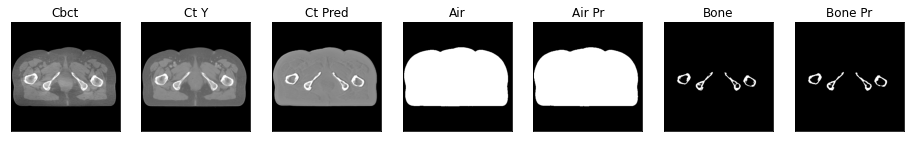

21it [00:46,  2.17s/it]

ssim score = 0.8102853298187256
psnr score = 21.319944381713867
snr score = 11.99669075012207
mae error = 0.04565022513270378
air dice score = 0.9981981718035874
bone dice score = 0.9364823760970391


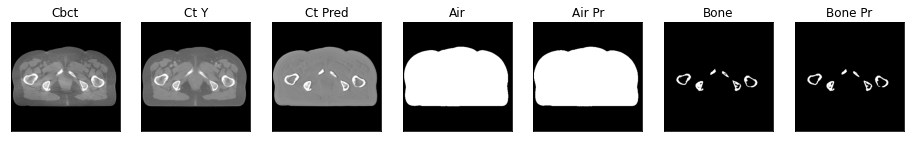

ssim score = 0.8115589022636414
psnr score = 21.285982131958008
snr score = 11.985684394836426
mae error = 0.0456102080643177
air dice score = 0.9984148203341308
bone dice score = 0.9321907600608758


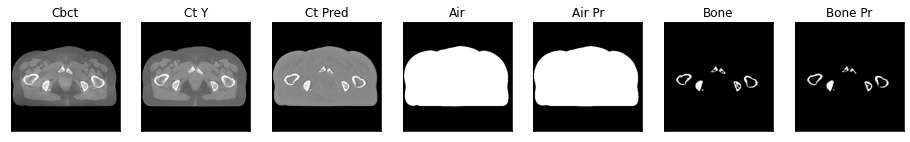

ssim score = 0.8075608611106873
psnr score = 21.328466415405273
snr score = 12.05949592590332
mae error = 0.045329753309488297
air dice score = 0.9985206345967464
bone dice score = 0.9262536873169939


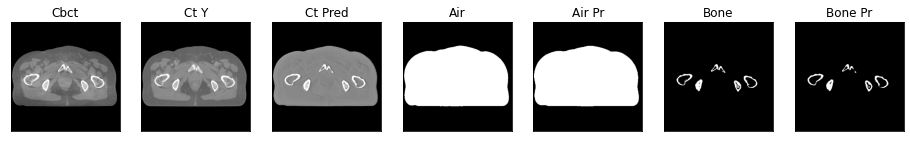

ssim score = 0.8075894713401794
psnr score = 21.39253807067871
snr score = 12.171930313110352
mae error = 0.04510132223367691
air dice score = 0.9979100064811661
bone dice score = 0.9195526695541206


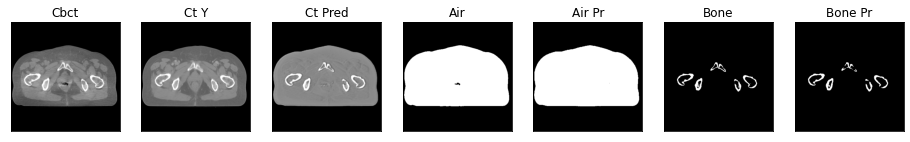

ssim score = 0.8039170503616333
psnr score = 21.253278732299805
snr score = 12.075414657592773
mae error = 0.04580101743340492
air dice score = 0.9978659402608958
bone dice score = 0.9282153539393783


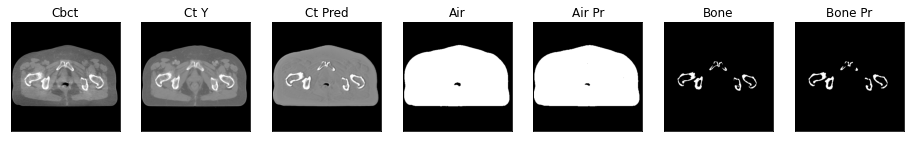

ssim score = 0.8012621998786926
psnr score = 21.205852508544922
snr score = 12.115690231323242
mae error = 0.046183306723833084
air dice score = 0.9977932340410052
bone dice score = 0.9056988777159933


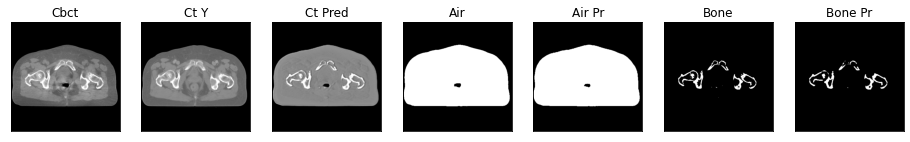

ssim score = 0.8079499006271362
psnr score = 21.6328125
snr score = 12.655925750732422
mae error = 0.044678978621959686
air dice score = 0.9975996925285915
bone dice score = 0.9125135754807225


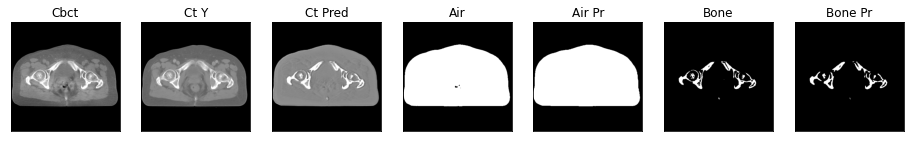

ssim score = 0.8113034963607788
psnr score = 21.513629913330078
snr score = 12.408187866210938
mae error = 0.044792477041482925
air dice score = 0.9971078103653772
bone dice score = 0.8911410099617134


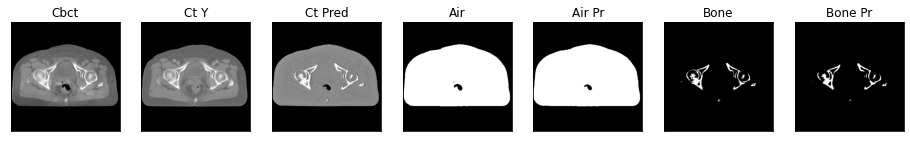

22it [00:48,  2.19s/it]

ssim score = 0.8151315450668335
psnr score = 21.624338150024414
snr score = 12.409477233886719
mae error = 0.04440417140722275
air dice score = 0.9972272628293553
bone dice score = 0.8861356932175785


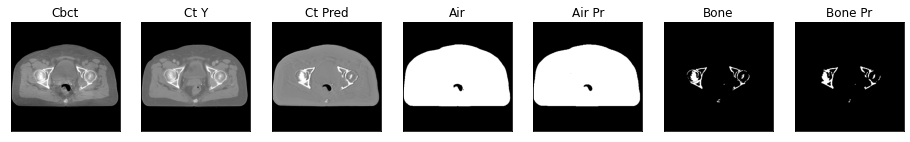

ssim score = 0.8184197545051575
psnr score = 21.50926399230957
snr score = 12.2672758102417
mae error = 0.04532383754849434
air dice score = 0.9974024846428254
bone dice score = 0.9008379888285468


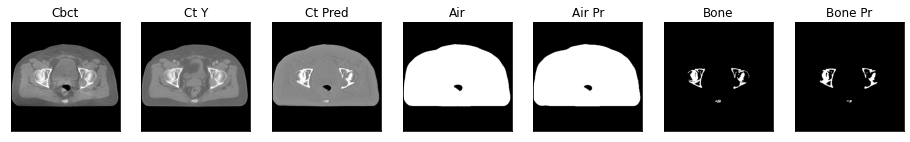

ssim score = 0.8193522095680237
psnr score = 21.572124481201172
snr score = 12.322132110595703
mae error = 0.0462648905813694
air dice score = 0.9975468395833949
bone dice score = 0.9202331390521193


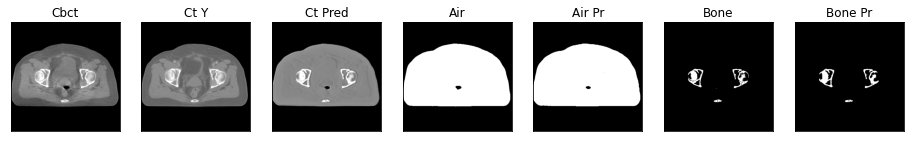

ssim score = 0.8162519335746765
psnr score = 21.54938507080078
snr score = 12.333621978759766
mae error = 0.04690960422158241
air dice score = 0.9980305583402669
bone dice score = 0.9340344168270549


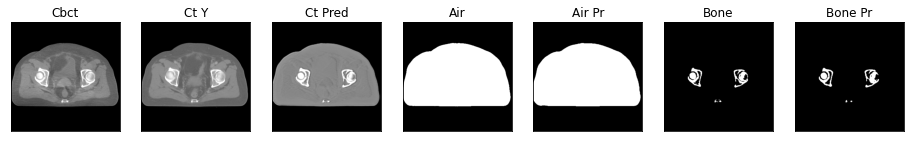

ssim score = 0.8145179748535156
psnr score = 21.21343231201172
snr score = 12.04916000366211
mae error = 0.048173677176237106
air dice score = 0.9980170911220738
bone dice score = 0.947368421053471


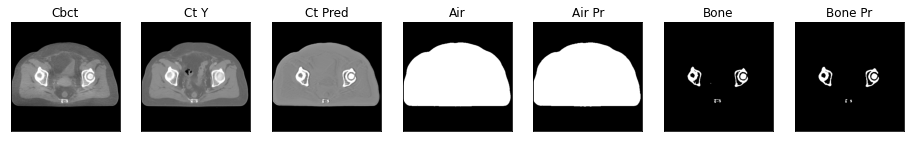

ssim score = 0.8027161359786987
psnr score = 20.896564483642578
snr score = 11.769851684570312
mae error = 0.04884171113371849
air dice score = 0.9980408620207123
bone dice score = 0.9497574497583202


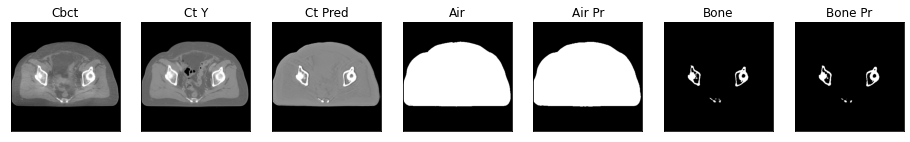

ssim score = 0.7897222638130188
psnr score = 20.265644073486328
snr score = 11.06649398803711
mae error = 0.05212532356381416
air dice score = 0.9961563857515231
bone dice score = 0.9313352717528218


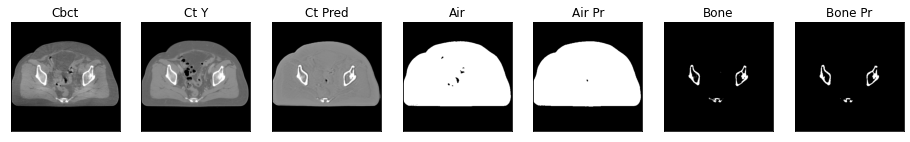

ssim score = 0.7871719002723694
psnr score = 20.141019821166992
snr score = 10.923873901367188
mae error = 0.05344251170754433
air dice score = 0.9950558632214261
bone dice score = 0.9413622011740784


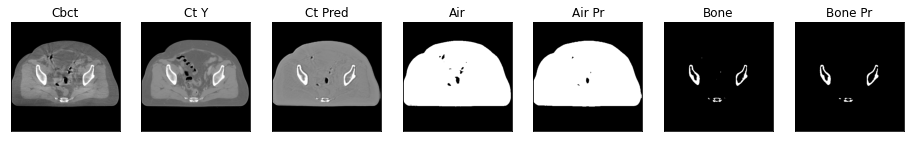

23it [00:50,  2.15s/it]

ssim score = 0.7860982418060303
psnr score = 20.383235931396484
snr score = 11.23100757598877
mae error = 0.05306776985526085
air dice score = 0.994847263035608
bone dice score = 0.9452954048152014


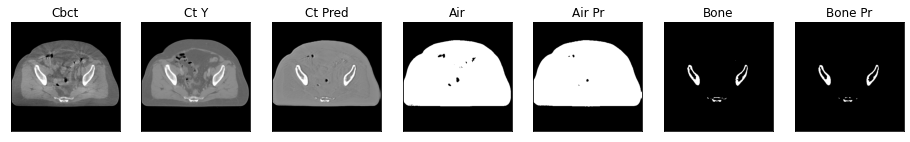

ssim score = 0.7853557467460632
psnr score = 20.1894588470459
snr score = 11.092324256896973
mae error = 0.05479656532406807
air dice score = 0.9954165141098169
bone dice score = 0.9362020579993227


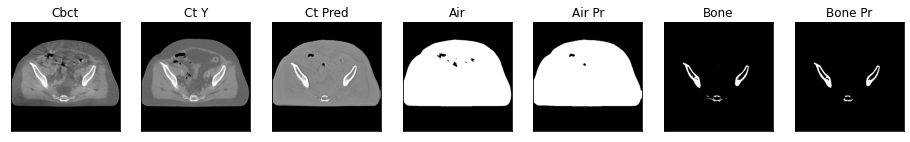

ssim score = 0.7774938344955444
psnr score = 19.706645965576172
snr score = 10.673940658569336
mae error = 0.05740050598978996
air dice score = 0.9955894495874789
bone dice score = 0.9394175362102567


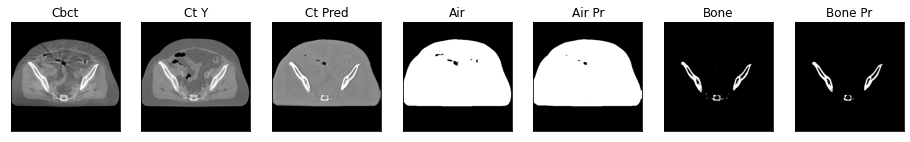

ssim score = 0.7734715938568115
psnr score = 19.688589096069336
snr score = 10.728741645812988
mae error = 0.05799134075641632
air dice score = 0.9950605778192018
bone dice score = 0.9228323699433116


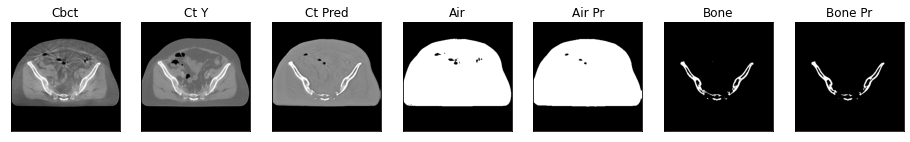

ssim score = 0.7690420746803284
psnr score = 19.674272537231445
snr score = 10.710136413574219
mae error = 0.0590384341776371
air dice score = 0.9949758033102953
bone dice score = 0.9109548916240341


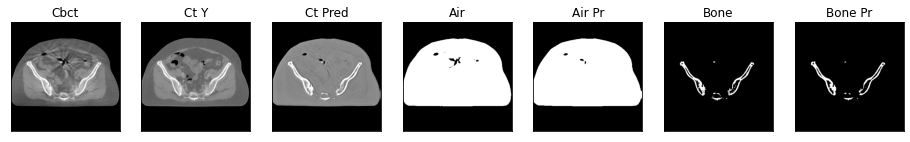

ssim score = 0.7691754698753357
psnr score = 19.550668716430664
snr score = 10.56435489654541
mae error = 0.060606010258197784
air dice score = 0.9957377820777686
bone dice score = 0.9115703641232733


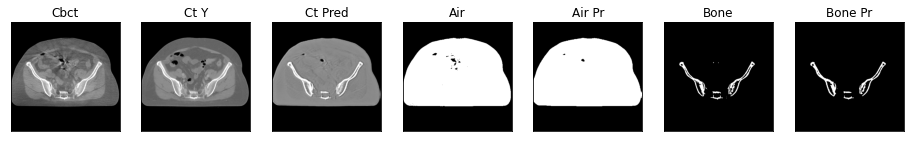

ssim score = 0.7745070457458496
psnr score = 19.830366134643555
snr score = 10.855688095092773
mae error = 0.05978188291192055
air dice score = 0.9970335250531135
bone dice score = 0.8981550922469154


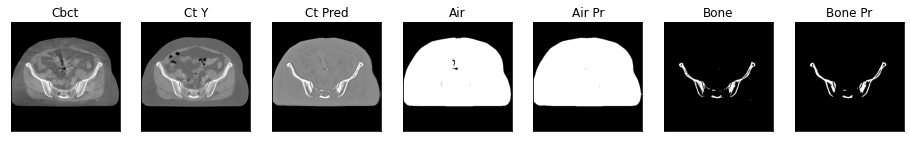

24it [00:52,  2.20s/it]


In [32]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [33]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [34]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [35]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:07,  3.40it/s]


(0.8032674317558607,
 21.04779863357544,
 12.062369346618652,
 0.04091981278421978,
 0.9956820056884209,
 0.9243623362700074,
 0.3333333333333333)